In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re
import textwrap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [ ]:
!conda update jupyterlab

In [ ]:
!jupyter labextension install @jupyterlab/toc

In [101]:
# Load the survey data from the Excel file
file_path = 'survey_submitted_8.xlsx'
survey_data = pd.read_excel(file_path, header=[0, 1])
#survey_data = pd.read_excel(file_path)

C:\Users\P256980\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [102]:
# Display the first few rows and column names to understand the structure of the data
survey_data.columns

MultiIndex([(          'Q1', ...),
            (   'Q1_9_TEXT', ...),
            (   'StartDate', ...),
            (     'EndDate', ...),
            (  'ResponseId', ...),
            ('RecordedDate', ...),
            (    'Finished', ...),
            (          'Q7', ...),
            (   'Q7_4_TEXT', ...),
            (        'Q9.1', ...),
            ( 'Q9.1_2_TEXT', ...),
            ( 'Q9.1_3_TEXT', ...),
            (  'Q10_1_TEXT', ...),
            (  'Q10_2_TEXT', ...),
            (  'Q10_3_TEXT', ...),
            (  'Q10_4_TEXT', ...),
            (  'Q10_5_TEXT', ...),
            (  'Q10_6_TEXT', ...),
            (  'Q10_7_TEXT', ...),
            (         'Q11', ...),
            (  'Q11_2_TEXT', ...),
            (  'Q11_5_TEXT', ...),
            (         'Q12', ...),
            (         'Q13', ...),
            (  'Q13_2_TEXT', ...),
            (         'Q14', ...),
            (  'Q14_2_TEXT', ...),
            (  'Q14_3_TEXT', ...),
            (       

In [103]:
# Flatten the multi-level header
survey_data.columns = [' '.join(col).strip() for col in survey_data.columns.values]

# Display the first few rows to verify the structure
survey_data.head()

Q1 What type of institute do you work in? (More than one option can be selected) - Selected Choice  \
0                 NWO-I Institute (CWI, AMOLF, etc.)                                                   
1             Applied University (Dutch: hogeschool)                                                   
2                                         University                                                   
3                 NWO-I Institute (CWI, AMOLF, etc.)                                                   
4                                         University                                                   

  Q1_9_TEXT What type of institute do you work in? (More than one option can be selected) - Other (please specify): - Text  \
0                                                NaN                                                                         
1                                                NaN                                                                         
2                                                NaN                                                                         
3                                                NaN                                                                         
4                                                NaN                                                                         

  StartDate Start Date    EndDate End Date ResponseId Response ID  \
0  2024-05-27 15:05:05 2024-05-27 15:11:40      R_2aA0f4oAE4HVBPH   
1  2024-05-27 15:09:21 2024-05-27 15:15:49      R_8ee5kcHaUYoL5w5   
2  2024-05-27 16:03:27 2024-05-27 16:14:20      R_2hTfx5RzGvv8jAF   
3  2024-05-27 16:37:43 2024-05-27 16:46:55      R_8ItqdeNac0SS443   
4  2024-05-27 16:39:48 2024-05-27 16:53:05      R_2I3FV9g5wyxI5vc   

  RecordedDate Recorded Date  Finished Finished  \
0    2024-05-27 15:11:40.996               True   
1    2024-05-27 15:15:49.743               True   
2    2024-05-27 16:14:21.272               True   
3    2024-05-27 16:46:55.642               True   
4    2024-05-27 16:53:06.239               True   

  Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice  \
0                               T3: Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                               T3: Specific Methods                                                                                                                                                                                                                                        

In [104]:
# Create a dictionary to rename columns

rename_dict = {
    'Q1 What type of institute do you work in? (More than one option can be selected) - Selected Choice': 'Question 1',
    'Q1_9_TEXT What type of institute do you work in? (More than one option can be selected) - Other (please specify): - Text':
    'Question 1 - Text entry',
    'Q2 What is your research field?': 'Question 2', 
    'Q3 What is your title in your institute? - Selected Choice': 'Question 3',
    'Q3_10_TEXT What is your title in your institute? - Other (please specify): - Text': 'Question 3 - Text entry',
    'Q4 Which of the following activities concerning research software do you spend your work time on? (More than one option can be selected) - Selected Choice': 
    'Question 4',
    'Q4_5_TEXT Which of the following activities concerning research software do you spend your work time on? (More than one option can be selected) - Other - Text': 
    'Question 4 - Text entry',
    'StartDate Start Date': 'Start Date',
    'EndDate End Date': 'End Date',
    'ResponseId Response ID': 'ResponseId',
    'RecordedDate Recorded Date': 'Recorded Date',
    'Finished Finished': 'Finished'
    
}

In [105]:
# Rename columns in the DataFrame
survey_data.rename(columns=rename_dict, inplace=True)

# Display the new column names to verify the renaming
survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [106]:
survey_data.head()

Question 1 Question 1 - Text entry  \
0      NWO-I Institute (CWI, AMOLF, etc.)                     NaN   
1  Applied University (Dutch: hogeschool)                     NaN   
2                              University                     NaN   
3      NWO-I Institute (CWI, AMOLF, etc.)                     NaN   
4                              University                     NaN   

           Start Date            End Date         ResponseId  \
0 2024-05-27 15:05:05 2024-05-27 15:11:40  R_2aA0f4oAE4HVBPH   
1 2024-05-27 15:09:21 2024-05-27 15:15:49  R_8ee5kcHaUYoL5w5   
2 2024-05-27 16:03:27 2024-05-27 16:14:20  R_2hTfx5RzGvv8jAF   
3 2024-05-27 16:37:43 2024-05-27 16:46:55  R_8ItqdeNac0SS443   
4 2024-05-27 16:39:48 2024-05-27 16:53:05  R_2I3FV9g5wyxI5vc   

            Recorded Date  Finished  \
0 2024-05-27 15:11:40.996      True   
1 2024-05-27 15:15:49.743      True   
2 2024-05-27 16:14:21.272      True   
3 2024-05-27 16:46:55.642      True   
4 2024-05-27 16:53:06.239      True   

  Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice  \
0                               T3: Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                               T3: Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2  T1: Contribution to Community,T2: Core Infrast...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [107]:
# Define your survey question columns and the 'Finished' column
survey_questions = ['Question 1', 'Question 1 - Text entry',
       'Question 2', 'Question 3',
       'Question 3 - Text entry', 'Question 4', 'Question 4 - Text entry']
finished_column = 'Finished'

In [108]:
survey_questions = ['Question 1', 'Question 1 - Text entry', 'Question 2', 'Question 3', 'Question 3 - Text entry', 'Question 4', 'Question 4 - Text entry']
multi_option_questions = ['Question 1', 'Question 1 - Text entry','Question 3', 'Question 3 - Text entry', 'Question 4', 'Question 4 - Text entry']

In [109]:
for question in survey_questions:
    question_data = survey_data[question].dropna()
    num_responses = len(question_data)
    print(f"\nAnalysis for '{question}':")
    print(f"Number of Non-Empty Responses: {num_responses}")


Analysis for 'Question 1':
Number of Non-Empty Responses: 100

Analysis for 'Question 1 - Text entry':
Number of Non-Empty Responses: 3

Analysis for 'Question 2':
Number of Non-Empty Responses: 100

Analysis for 'Question 3':
Number of Non-Empty Responses: 100

Analysis for 'Question 3 - Text entry':
Number of Non-Empty Responses: 21

Analysis for 'Question 4':
Number of Non-Empty Responses: 100

Analysis for 'Question 4 - Text entry':
Number of Non-Empty Responses: 5


In [110]:
for row in survey_data[['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4']].itertuples(index=False):
    i, j, k, l, m = row
    print(i,j)

R_2aA0f4oAE4HVBPH NWO-I Institute (CWI, AMOLF, etc.)
R_8ee5kcHaUYoL5w5 Applied University (Dutch: hogeschool)
R_2hTfx5RzGvv8jAF University
R_8ItqdeNac0SS443 NWO-I Institute (CWI, AMOLF, etc.)
R_2I3FV9g5wyxI5vc University
R_2XJpO9TH2C0DPI5 University
R_8CqpcAwarNRX4pH Other Organizations that produce/play a major role in research software in the Netherlands (eScience Center, DANS, SURF)
R_8duzFUcP5i65ilG University
R_8uKfqPnTuAj4w5X University
R_8PdUQA4vf0CMHkU Large Enterprise (50 or more people),Other (please specify):
R_22DcE1w1PAf5Cut University
R_2b8J34d2a794b17 Other (please specify):
R_8In25kGNZiKlxvm University
R_2dFQYyVUJYthnoc University
R_27wJg7cL63sKMRk University
R_8fK5TQFXzKcp5B8 University
R_1GkTlxwXbunbc3g NWO-I Institute (CWI, AMOLF, etc.)
R_89keZ93ks5d9Kg1 University
R_2NCmjyO0XroRosx Other Organizations that produce/play a major role in research software in the Netherlands (eScience Center, DANS, SURF)
R_3ImsSnBppgFN1UB NWO-I Institute (CWI, AMOLF, etc.)
R_8e2ZkbrBdEx

In [111]:
# Calculate the total number of entries in the DataFrame
total_entries = len(survey_data)

# Select the relevant columns
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4']

# Count the rows where all specified columns are non-NaN
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

print(f"Number of rows where all columns are non-NaN: {num_complete_answers}\n"
      f"total number of submitted surveys are: {total_entries}")

Number of rows where all columns are non-NaN: 100
total number of submitted surveys are: 100


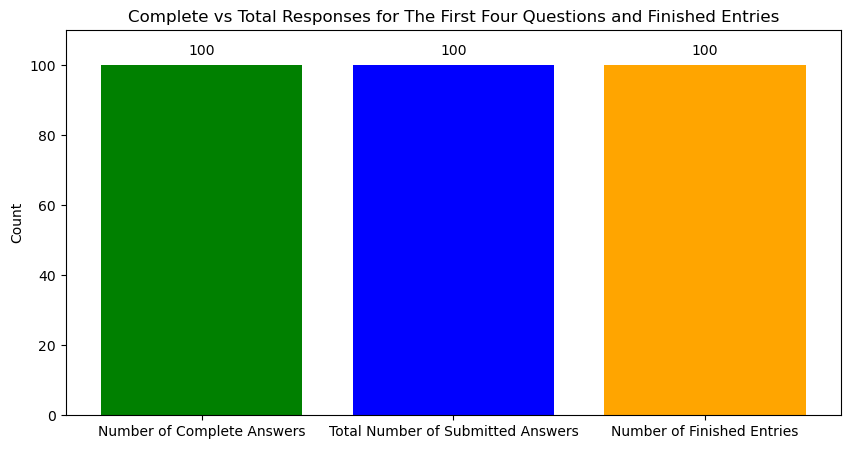

In [112]:
# Calculate the total number of entries in the DataFrame
total_entries = len(survey_data)

# Calculate the number of rows where all specified columns are non-NaN
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Calculate the number of rows where 'Finished' is True
num_finished = survey_data[survey_data['Finished'] == True].shape[0]

# Data for plotting
labels = ['Number of Complete Answers', 'Total Number of Submitted Answers', 'Number of Finished Entries']
values = [num_complete_answers, total_entries, num_finished]

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=['green', 'blue', 'orange'])

# Add labels and title
plt.ylabel('Count')
plt.title('Complete vs Total Responses for The First Four Questions and Finished Entries')
plt.ylim(0, max(total_entries, num_complete_answers, num_finished) * 1.1)  # Adjust the y-axis limit for better visualization

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + (total_entries * 0.02), str(v), ha='center', va='bottom')

# Show the plot
plt.show()


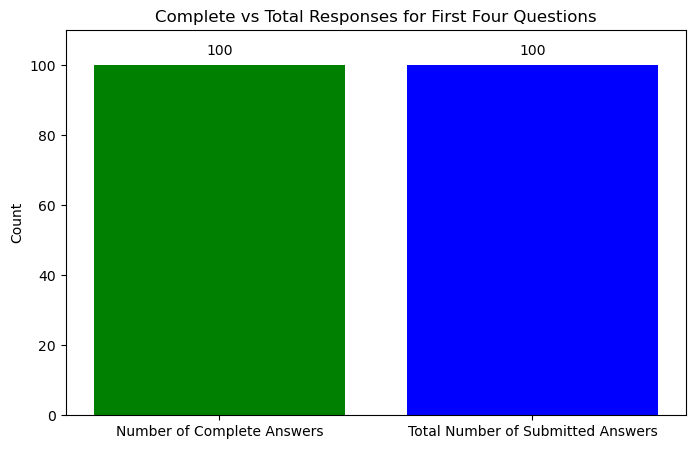

In [116]:
# Calculate the total number of entries in the DataFrame
total_entries = len(survey_data)

# Calculate the number of rows where all specified columns are non-NaN
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Data for plotting
labels = ['Number of Complete Answers', 'Total Number of Submitted Answers']
values = [num_complete_answers, total_entries]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['green', 'blue'])

# Add labels and title
plt.ylabel('Count')
plt.title('Complete vs Total Responses for First Four Questions')
plt.ylim(0, max(total_entries, num_complete_answers) * 1.1)  # Adjust the y-axis limit for better visualization

# Display the values on the bars
for i, v in enumerate(values):
    plt.text(i, v + (total_entries * 0.02), str(v), ha='center', va='bottom')

# Show the plot
plt.show()

In [114]:
print(num_complete_answers)

100


## Question 1

### Check the unique anwers for question 1

In [18]:
survey_data['Question 1'].unique()

array(['NWO-I Institute (CWI, AMOLF, etc.)',
       'Applied University (Dutch: hogeschool)', 'University',
       'Other Organizations that produce/play a major role in research software in the Netherlands (eScience Center, DANS, SURF)',
       'Large Enterprise (50 or more people),Other (please specify):',
       'Other (please specify):',
       'University,Small or Medium Enterprise (less than 50 people)',
       'University,NWO-I Institute (CWI, AMOLF, etc.)',
       'Government (KNMI, RIVM, PBL, etc.)'], dtype=object)

In [19]:
survey_data['Question 1'].nunique()

9

In [20]:
survey_data['Question 1'].value_counts().sum()

100

In [21]:
# Define the replacements dictionary
replacements = {
    'NWO-I Institute (CWI, AMOLF, etc.)': 'NWO-I Institute',
    'Other Organizations that produce/play a major role in research software in the Netherlands (eScience Center, DANS, SURF)': 'eScience Center/DANS/SURF',
    'Applied University (Dutch: hogeschool)': 'Applied University',
    'Small or Medium Enterprise (less than 50 people)': 'Small Enterprise',
    'Large Enterprise (50 or more people)': 'Large Enterprise',
    'University': 'University',
    'Government (KNMI, RIVM, PBL, etc.)': 'Government',
    'TO2 Organisation (Deltares, TNO, etc.)': 'TO2 Organisation',
    'Other (please specify):': 'Other',
    'Large Enterprise (50 or more people),Other (please specify):': 'Large Enterprise & Other',
    'University,Small or Medium Enterprise (less than 50 people)': 'University & Small Enterprise',
    'University,NWO-I Institute (CWI, AMOLF, etc.)': 'University & NWO-I Institute',
    'University,TO2 Organisation (Deltares, TNO, etc.)': 'University & TO2 Organisation'

}

# Apply the replacements to the 'Question 1' column
survey_data['Question 1 Simplified'] = survey_data['Question 1'].replace(replacements)

# Display the DataFrame to check the results
survey_data['Question 1 Simplified']

0        NWO-I Institute
1     Applied University
2             University
3        NWO-I Institute
4             University
             ...        
95            University
96            University
97            University
98            University
99            University
Name: Question 1 Simplified, Length: 100, dtype: object

In [22]:
# Define columns to check and calculate the number of complete answers
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4','Question 1 Simplified']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Filter the DataFrame based on the completeness condition
filtered_data = survey_data[survey_data[columns_to_check].notna().all(axis=1)]

In [23]:
len(filtered_data['Question 1 Simplified'])

100

In [24]:
filtered_data['Question 1 Simplified'].unique()

array(['NWO-I Institute', 'Applied University', 'University',
       'eScience Center/DANS/SURF', 'Large Enterprise & Other', 'Other',
       'University & Small Enterprise', 'University & NWO-I Institute',
       'Government'], dtype=object)

In [25]:
filtered_data['Question 1 Simplified'].value_counts()

University                       58
NWO-I Institute                  19
eScience Center/DANS/SURF        11
University & NWO-I Institute      5
Applied University                2
Other                             2
Large Enterprise & Other          1
University & Small Enterprise     1
Government                        1
Name: Question 1 Simplified, dtype: int64

In [26]:
filtered_data['Question 1 Simplified'].value_counts().sum()

100

### Plot the distribution of answers of Q1 for the first level cleaned data 

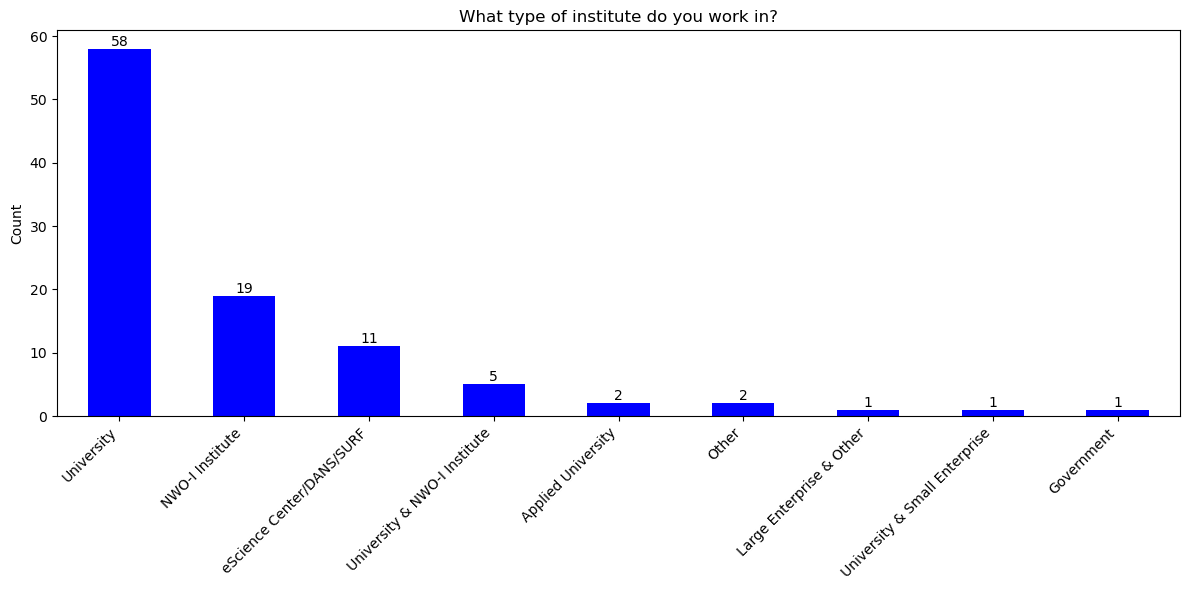

In [27]:
answer_counts= filtered_data['Question 1 Simplified'].value_counts()


plt.figure(figsize=(12, 6))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('What type of institute do you work in?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

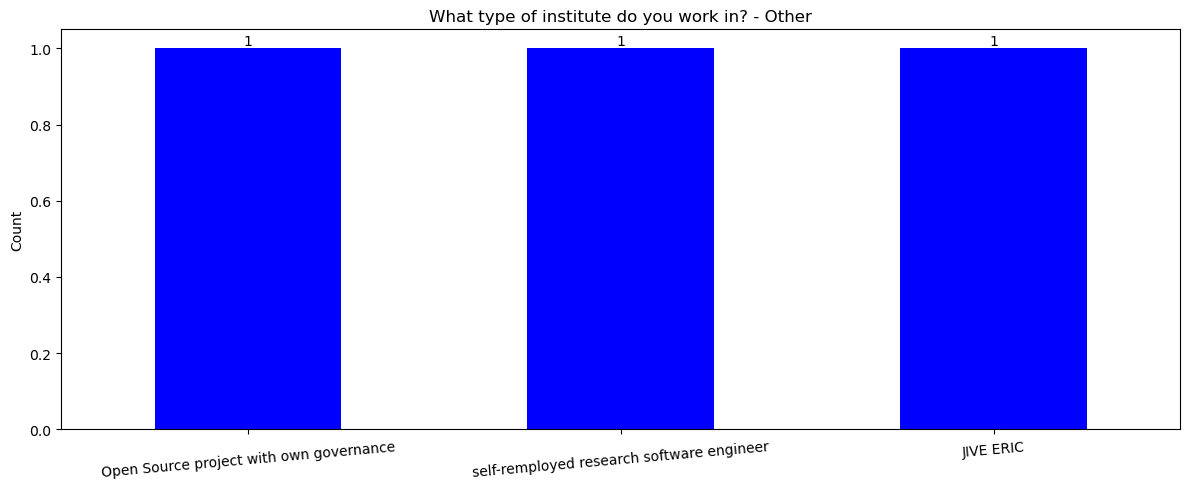

In [28]:
answer_counts=filtered_data['Question 1 - Text entry'].dropna().value_counts()

plt.figure(figsize=(12, 5))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('What type of institute do you work in? - Other')
plt.xticks(rotation=5, ha='center')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Question 2

### Check the unique anwers for question 2

In [29]:
survey_data['Question 2'].unique()

array(['Astronomy', 'physics',
       'Life sciences - biochemistry - Mass Spectrometry',
       'Radioastronomy', 'Geo-informatics', 'Statistics',
       'Computational science', 'Bioinformatics', 'open quantum systems',
       'Originally Physics, now working in different fields (Physics, Astronomy, History, Medicine, etc.)',
       'life sciences', 'Software Engineering', 'Social sciences',
       'computer science', 'Geosciences', 'computational physics',
       'Climate science', 'Life sciences', 'Imaging', 'research software',
       'physics of granular materials', 'None',
       'Natural Sciences & Engineering', 'Artificial intelligence',
       'Astrophysics', 'Earth Observation', 'Sensors and smart systems',
       'Data Science', 'mathematics', 'coastal engineering',
       'plasma physics', 'Fusion', 'Data processing for radio astronomy',
       'Hydrology', 'Physics', 'Hydrometeorology',
       'Planetary Astrophysics', 'Computer Science',
       'Geoinformation processing

In [30]:
# Define columns to check and calculate the number of complete answers
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Filter the DataFrame based on the completeness condition
filtered_data = survey_data[survey_data[columns_to_check].notna().all(axis=1)]

In [31]:
filtered_data['Question 2'].nunique()

79

In [32]:
filtered_data['Question 2'].unique()

array(['Astronomy', 'physics',
       'Life sciences - biochemistry - Mass Spectrometry',
       'Radioastronomy', 'Geo-informatics', 'Statistics',
       'Computational science', 'Bioinformatics', 'open quantum systems',
       'Originally Physics, now working in different fields (Physics, Astronomy, History, Medicine, etc.)',
       'life sciences', 'Software Engineering', 'Social sciences',
       'computer science', 'Geosciences', 'computational physics',
       'Climate science', 'Life sciences', 'Imaging', 'research software',
       'physics of granular materials', 'None',
       'Natural Sciences & Engineering', 'Artificial intelligence',
       'Astrophysics', 'Earth Observation', 'Sensors and smart systems',
       'Data Science', 'mathematics', 'coastal engineering',
       'plasma physics', 'Fusion', 'Data processing for radio astronomy',
       'Hydrology', 'Physics', 'Hydrometeorology',
       'Planetary Astrophysics', 'Computer Science',
       'Geoinformation processing

In [33]:
print(len(filtered_data['Question 2']))

100


In [34]:
filtered_data['Question 2'].value_counts().sum()

100

In [35]:
len(filtered_data['Question 2'].unique())

79

In [36]:
answers= filtered_data['Question 2']
# Convert to lowercase
answers = [ans.lower() if isinstance(ans, str) else '' for ans in answers]

In [37]:
len(answers)

100

In [38]:
# Convert to lowercase and strip any extra spaces
answers = [ans.lower().strip() if isinstance(ans, str) else '' for ans in answers]

# Define categorization function
def categorize_answer(answer):
    if 'astro' in answer or 'astr' in answer or 'astronomy' in answer or 'asstrophysics' in answer:
        return 'Astronomy'
    elif 'research software' in answer:
        return 'Research Software'
    elif 'chemistry' in answer or 'chem' in answer:
        return 'Chemistry'
    elif 'physics' in answer:
        return 'Physics'
    else:
        return 'Other'

# Apply categorization
categorized_answers = [categorize_answer(ans) for ans in answers]

# Create DataFrame
df_filtered = pd.DataFrame({'Answer': answers, 'Category': categorized_answers})

# Display categorized data
print(df_filtered['Category'].value_counts())

Other                56
Astronomy            26
Physics               9
Chemistry             8
Research Software     1
Name: Category, dtype: int64


In [39]:
# Display names under the 'Research Software' category
research_software_names = df_filtered[df_filtered['Category'] == 'Research Software']['Answer'].unique()
print("Names under 'Research Software':")
print(research_software_names)

Names under 'Research Software':
['research software']


In [40]:
# Display names under the 'Astronomy' category
astronomy_names = df_filtered[df_filtered['Category'] == 'Astronomy']['Answer'].unique()
print("Names under 'Astronomy':")
print(astronomy_names)

Names under 'Astronomy':
['astronomy' 'radioastronomy'
 'originally physics, now working in different fields (physics, astronomy, history, medicine, etc.)'
 'astrophysics' 'data processing for radio astronomy'
 'planetary astrophysics'
 'very long baseline interferometry (radio astronomy technique)'
 'astronomy, data science' 'asstrophysics' 'astronomy and computing']


In [41]:
# Display names under the 'Chemistry' category
chemistry_names = df_filtered[df_filtered['Category'] == 'Chemistry']['Answer'].unique()
print("Names under 'Chemistry':")
print(chemistry_names)

Names under 'Chemistry':
['life sciences - biochemistry - mass spectrometry' 'chemistry'
 'theoretical chemistry' 'organic chemistry' 'chemical biology'
 'physical chemistry']


In [76]:
# Display names under the 'Other' category
other_names = df_filtered[df_filtered['Category'] == 'Other']['Answer'].unique()
print("Names under 'Other':")
print(other_names)

Names under 'Other':
['geo-informatics' 'statistics' 'computational science' 'bioinformatics'
 'open quantum systems' 'life sciences' 'software engineering'
 'social sciences' 'computer science' 'geosciences' 'climate science'
 'imaging' 'none' 'natural sciences & engineering'
 'artificial intelligence' 'earth observation' 'sensors and smart systems'
 'data science' 'mathematics' 'coastal engineering' 'fusion' 'hydrology'
 'hydrometeorology'
 'geoinformation processing applied to water sanitation and health'
 'environmental and geosciences'
 'applied mathematics + scientific computing'
 'formal logic and cognitive science' 'computational mathematics'
 'environmental sciences' 'numerical mathematics' 'machine learning'
 'design engineering science (industrial design)' 'applied mathematics'
 'cross-domain research' 'granular materials' 'applied cs'
 'mechanical engineering' 'material discovery' 'sustainability sciences'
 'theoretical macroecology and ecotoxicology' 'medical biology'
 'in

In [43]:
print(df_filtered[df_filtered['Category'] == 'Other']['Answer'].value_counts())

computer science                                                    3
artificial intelligence                                             3
environmental sciences                                              2
bioinformatics                                                      2
life sciences                                                       2
mathematics                                                         2
material discovery                                                  1
numerical mathematics                                               1
machine learning                                                    1
design engineering science (industrial design)                      1
applied mathematics                                                 1
cross-domain research                                               1
granular materials                                                  1
applied cs                                                          1
mechanical engineeri

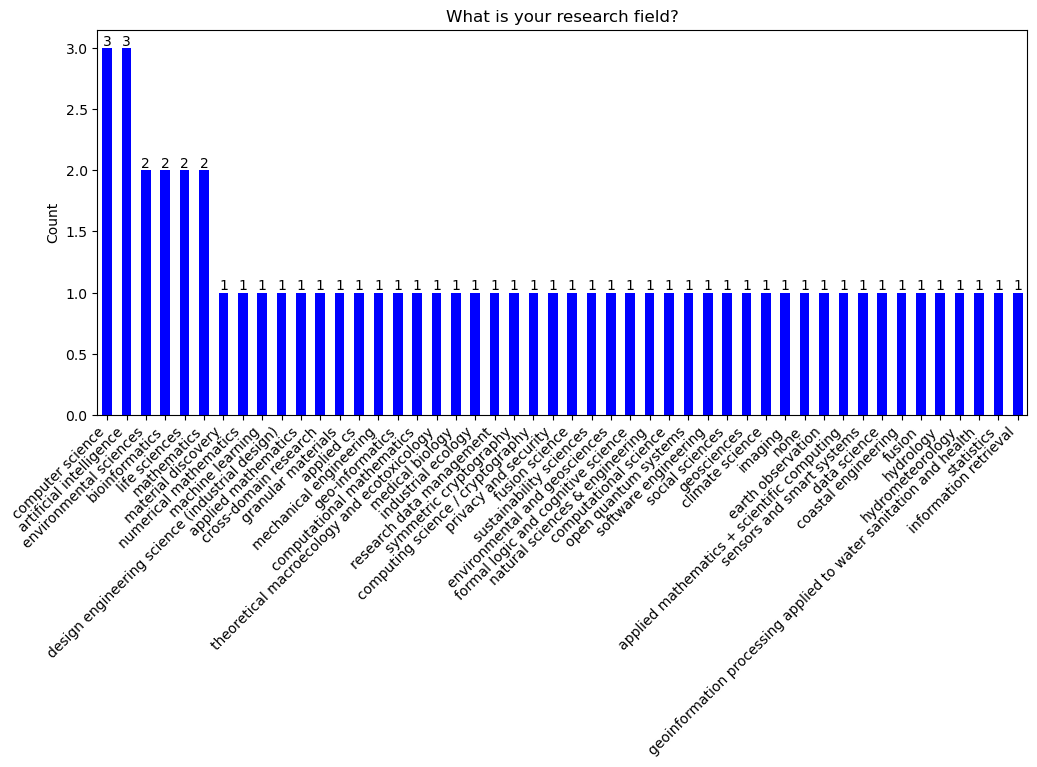

In [44]:
# Plot distribution
category_counts = df_filtered[df_filtered['Category'] == 'Other']['Answer'].value_counts()
plt.figure(figsize=(12, 5))
category_counts.plot(kind='bar',color='blue')
#plt.xlabel('Simplified Research Fields')
plt.ylabel('Count')
plt.title('What is your research field?')
plt.xticks(rotation=45, ha='right')

# Add counts on the plot
for index, value in enumerate(category_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
    
plt.show()

In [45]:
df_filtered[df_filtered['Category'] == 'Other']['Answer'].nunique()

48

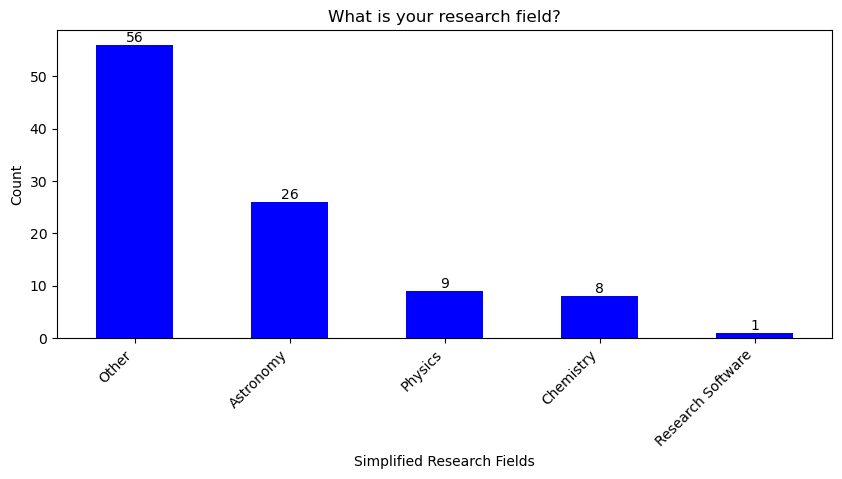

In [46]:

# Plot distribution
category_counts = df_filtered['Category'].value_counts()
plt.figure(figsize=(10, 4))
category_counts.plot(kind='bar',color='blue')
plt.xlabel('Simplified Research Fields')
plt.ylabel('Count')
plt.title('What is your research field?')
plt.xticks(rotation=45, ha='right')

# Add counts on the plot
for index, value in enumerate(category_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
    
plt.show()


In [47]:
filtered_data['Question 2'].value_counts()

Astronomy              11
Astrophysics            5
Physics                 3
Bioinformatics          2
astrophysics            2
                       ..
Fusion                  1
plasma physics          1
coastal engineering     1
mathematics             1
Mathematics             1
Name: Question 2, Length: 79, dtype: int64

In [48]:
filtered_data['Question 2'].value_counts().sum()

100

### Plot the distribution of answers of Q2 for the first level cleaned data 

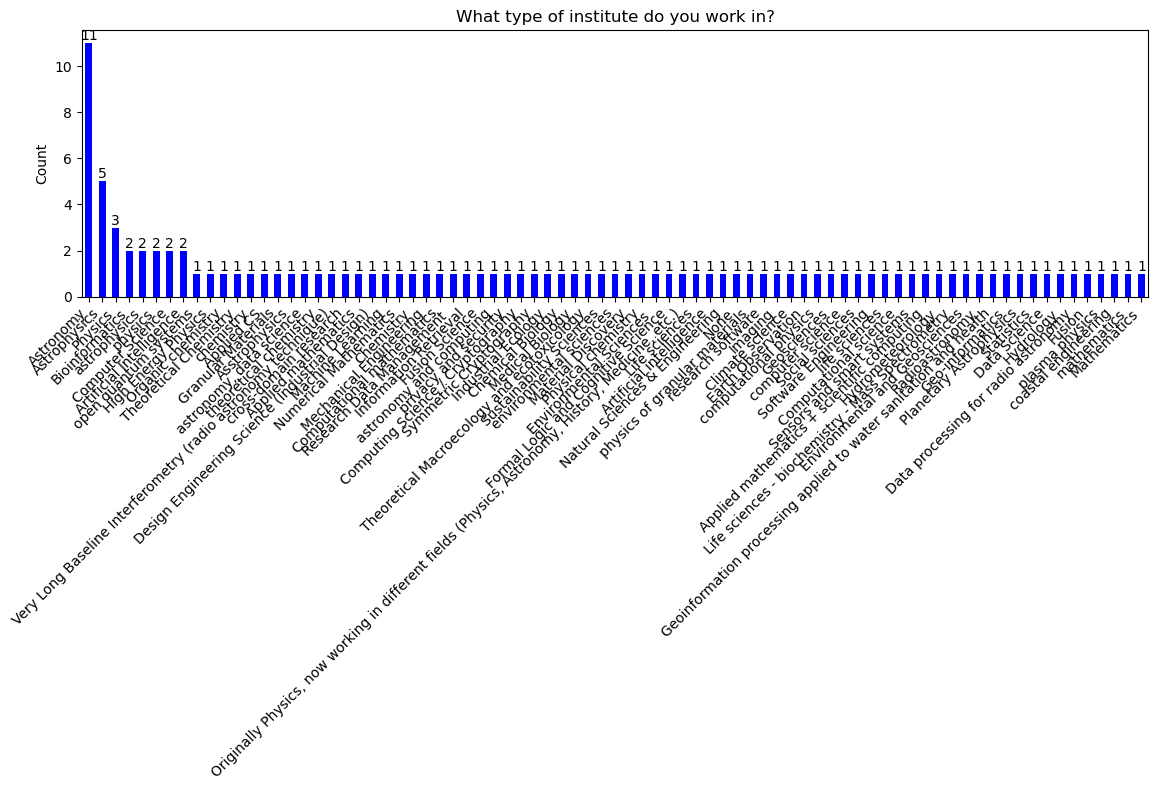

In [49]:
answer_counts= filtered_data['Question 2'].value_counts()


plt.figure(figsize=(12, 8))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('What type of institute do you work in?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Question 3

### Check the unique answers for question 3

In [50]:
survey_data['Question 3'].unique()

array(['Other (please specify):', 'Data manager', 'PhD',
       'Research software engineer', 'Assistant professor',
       'Postdoctoral fellow', 'Software developer', 'Associate professor',
       'Professor', 'MSc student'], dtype=object)

In [51]:
survey_data['Question 3'].value_counts().sum()

100

In [52]:
# Define the replacements dictionary
replacements = {
    'Other (please specify):': 'Other',
}

# Apply the replacements to the 'Question 1' column
survey_data['Question 3 Simplified'] = survey_data['Question 3'].replace(replacements)

# Display the DataFrame to check the results
survey_data['Question 3 Simplified']

0                          Other
1                   Data manager
2                            PhD
3                          Other
4     Research software engineer
                 ...            
95                     Professor
96           Assistant professor
97           Associate professor
98                     Professor
99           Associate professor
Name: Question 3 Simplified, Length: 100, dtype: object

In [53]:
# Define columns to check and calculate the number of complete answers
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4','Question 3 Simplified']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Filter the DataFrame based on the completeness condition
filtered_data = survey_data[survey_data[columns_to_check].notna().all(axis=1)]

In [54]:
len(filtered_data['Question 3 Simplified'])

100

In [55]:
filtered_data['Question 3 Simplified'].unique()

array(['Other', 'Data manager', 'PhD', 'Research software engineer',
       'Assistant professor', 'Postdoctoral fellow', 'Software developer',
       'Associate professor', 'Professor', 'MSc student'], dtype=object)

In [56]:
filtered_data['Question 3 Simplified'].value_counts()

Other                         21
Research software engineer    17
Assistant professor           15
PhD                           14
Professor                     12
Associate professor           10
Postdoctoral fellow            5
Data manager                   3
Software developer             2
MSc student                    1
Name: Question 3 Simplified, dtype: int64

In [57]:
filtered_data['Question 3 Simplified'].value_counts().sum()

100

### Plot the distribution of answers of Q3 for the first level cleaned data 

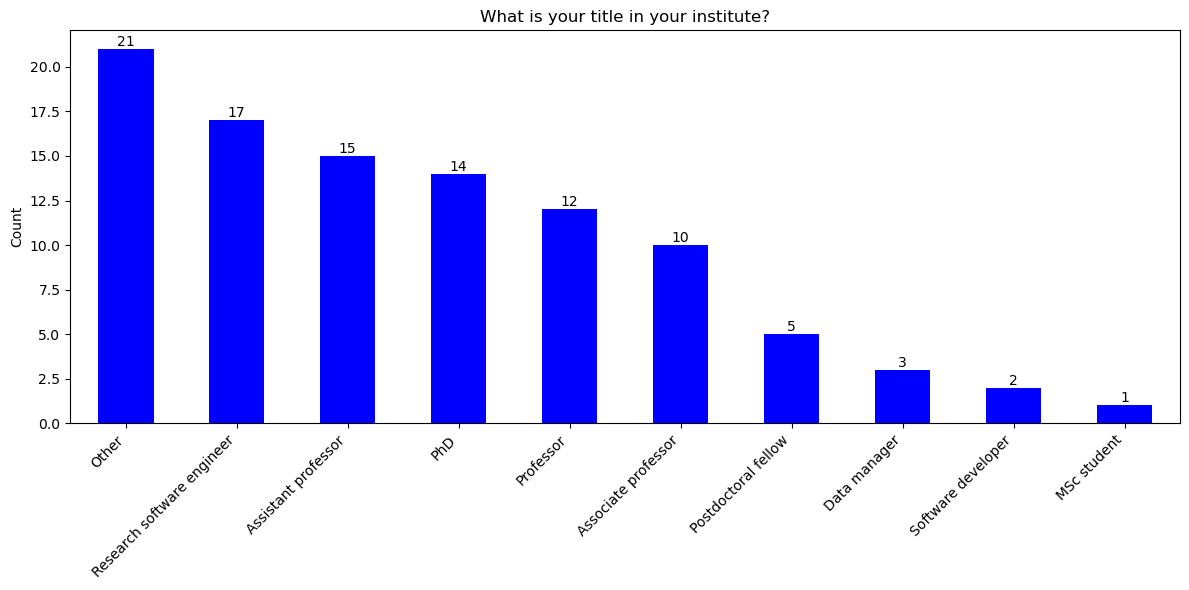

In [58]:
answer_counts= filtered_data['Question 3 Simplified'].value_counts()


plt.figure(figsize=(12, 6))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('What is your title in your institute?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

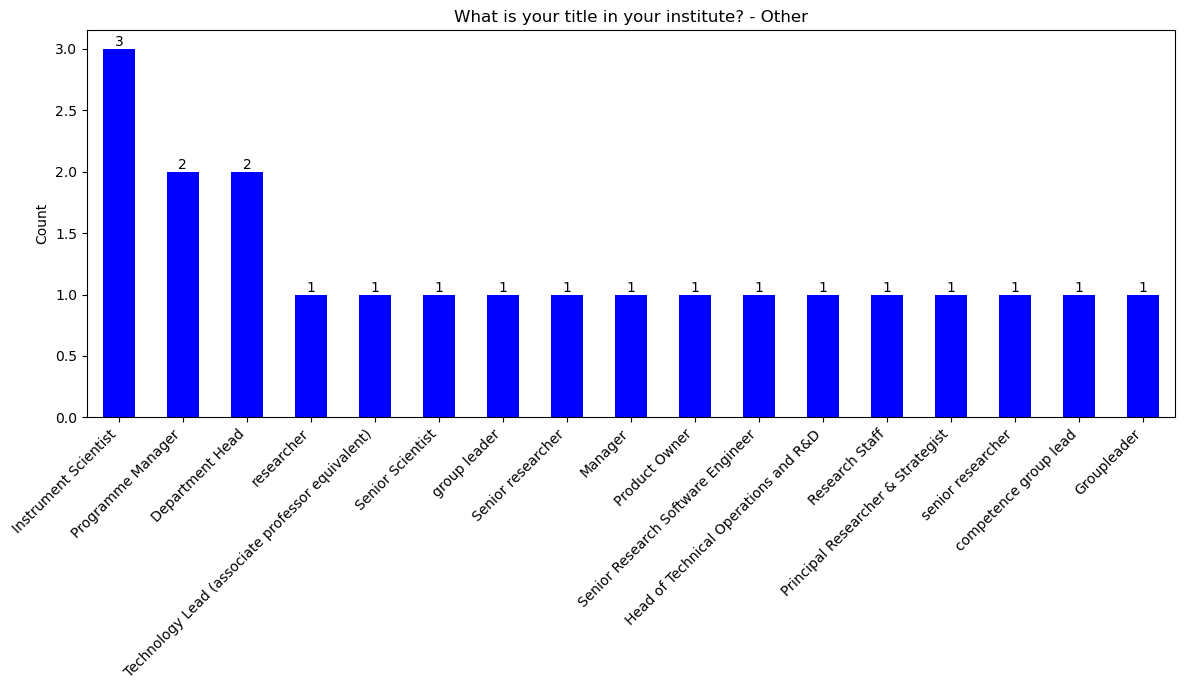

In [59]:
answer_counts=filtered_data['Question 3 - Text entry'].dropna().value_counts()

plt.figure(figsize=(12, 7))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('What is your title in your institute? - Other')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Question 4

### Check the unique answers for question 4

In [60]:
survey_data['Question 4'].unique()

array(['Develop  research software,Maintain research software,Use it as part of my own research',
       'Facilitate others or manage others to do so',
       'Develop  research software,Facilitate others or manage others to do so,Use it as part of my own research',
       'Develop  research software,Facilitate others or manage others to do so',
       'Develop  research software,Maintain research software',
       'Develop  research software,Maintain research software,Facilitate others or manage others to do so,Use it as part of my own research',
       'Develop  research software,Maintain research software,Facilitate others or manage others to do so',
       'Develop  research software',
       'Develop  research software,Use it as part of my own research',
       'Use it as part of my own research,None',
       'Develop  research software,Other',
       'Use it as part of my own research',
       'Develop  research software,Maintain research software,Facilitate others or manage othe

In [61]:
survey_data['Question 4'].value_counts()

Develop  research software,Maintain research software,Facilitate others or manage others to do so,Use it as part of my own research          28
Develop  research software,Maintain research software,Facilitate others or manage others to do so                                            13
Develop  research software,Maintain research software,Use it as part of my own research                                                      10
Facilitate others or manage others to do so                                                                                                   8
Develop  research software,Use it as part of my own research                                                                                  8
Develop  research software,Facilitate others or manage others to do so,Use it as part of my own research                                      6
Develop  research software,Maintain research software                                                                                   

In [62]:
survey_data['Question 4'].value_counts().sum()

100

In [63]:
def simplify_answers(answer):
    # Define keywords and their corresponding simplified labels
    keywords_to_labels = {
        'develop research software': 'Develop',
        'maintain research software': 'Maintain',
        'facilitate others or manage others to do so': 'Facilitate/Manage',
        'use it as part of my own research': 'Use',
        'none': 'None',
        'other': 'Other'
    }
    
    # Initialize a set to collect the matched labels for the answer
    labels = set()

    # Ensure the answer is a string
    if isinstance(answer, str):
        # Standardize the answer by lowercasing and removing extra spaces
        clean_answer = ' '.join(answer.lower().split())

        # Check for each keyword in the answer
        for keyword, label in keywords_to_labels.items():
            if keyword in clean_answer:
                labels.add(label)
    
    # If no labels are found, mark as "Other Combination"
    if not labels:
        return 'Other Combination'
    
    # Return the simplified label by joining the found labels
    return ', '.join(sorted(labels))

# Apply the function to simplify the answers in 'Question 4'
survey_data['Question 4 Simplified'] = survey_data['Question 4'].apply(simplify_answers)

# View the unique simplified answers
simplified_unique_answers = survey_data['Question 4 Simplified'].unique()
print(simplified_unique_answers)


['Develop, Maintain, Use' 'Facilitate/Manage, Other'
 'Develop, Facilitate/Manage, Other, Use'
 'Develop, Facilitate/Manage, Other' 'Develop, Maintain'
 'Develop, Facilitate/Manage, Maintain, Other, Use'
 'Develop, Facilitate/Manage, Maintain, Other' 'Develop' 'Develop, Use'
 'None, Use' 'Develop, Other' 'Use' 'Facilitate/Manage, Other, Use'
 'Develop, Maintain, Other, Use' 'None']


In [64]:
# Display the DataFrame to check the results
survey_data['Question 4 Simplified']

0                               Develop, Maintain, Use
1                             Facilitate/Manage, Other
2               Develop, Facilitate/Manage, Other, Use
3                             Facilitate/Manage, Other
4                    Develop, Facilitate/Manage, Other
                            ...                       
95                              Develop, Maintain, Use
96    Develop, Facilitate/Manage, Maintain, Other, Use
97                              Develop, Maintain, Use
98                       Facilitate/Manage, Other, Use
99    Develop, Facilitate/Manage, Maintain, Other, Use
Name: Question 4 Simplified, Length: 100, dtype: object

In [65]:
# Define columns to check and calculate the number of complete answers
columns_to_check = ['ResponseId', 'Question 1', 'Question 2', 'Question 3', 'Question 4','Question 4 Simplified']
num_complete_answers = survey_data[columns_to_check].notna().all(axis=1).sum()

# Filter the DataFrame based on the completeness condition
filtered_data = survey_data[survey_data[columns_to_check].notna().all(axis=1)]

len(filtered_data['Question 4 Simplified'])

100

In [66]:
filtered_data['Question 4 Simplified'].unique()

array(['Develop, Maintain, Use', 'Facilitate/Manage, Other',
       'Develop, Facilitate/Manage, Other, Use',
       'Develop, Facilitate/Manage, Other', 'Develop, Maintain',
       'Develop, Facilitate/Manage, Maintain, Other, Use',
       'Develop, Facilitate/Manage, Maintain, Other', 'Develop',
       'Develop, Use', 'None, Use', 'Develop, Other', 'Use',
       'Facilitate/Manage, Other, Use', 'Develop, Maintain, Other, Use',
       'None'], dtype=object)

In [67]:
filtered_data['Question 4 Simplified'].value_counts()

Develop, Facilitate/Manage, Maintain, Other, Use    30
Develop, Facilitate/Manage, Maintain, Other         13
Develop, Maintain, Use                              10
Facilitate/Manage, Other                             8
Develop, Use                                         8
Develop, Facilitate/Manage, Other, Use               6
Develop, Maintain                                    5
Develop                                              4
Use                                                  4
Facilitate/Manage, Other, Use                        4
Develop, Facilitate/Manage, Other                    3
None                                                 2
None, Use                                            1
Develop, Other                                       1
Develop, Maintain, Other, Use                        1
Name: Question 4 Simplified, dtype: int64

In [68]:
filtered_data['Question 4 Simplified'].value_counts().sum()

100

### Plot the distribution of answers of Q4 for the first level cleaned data 

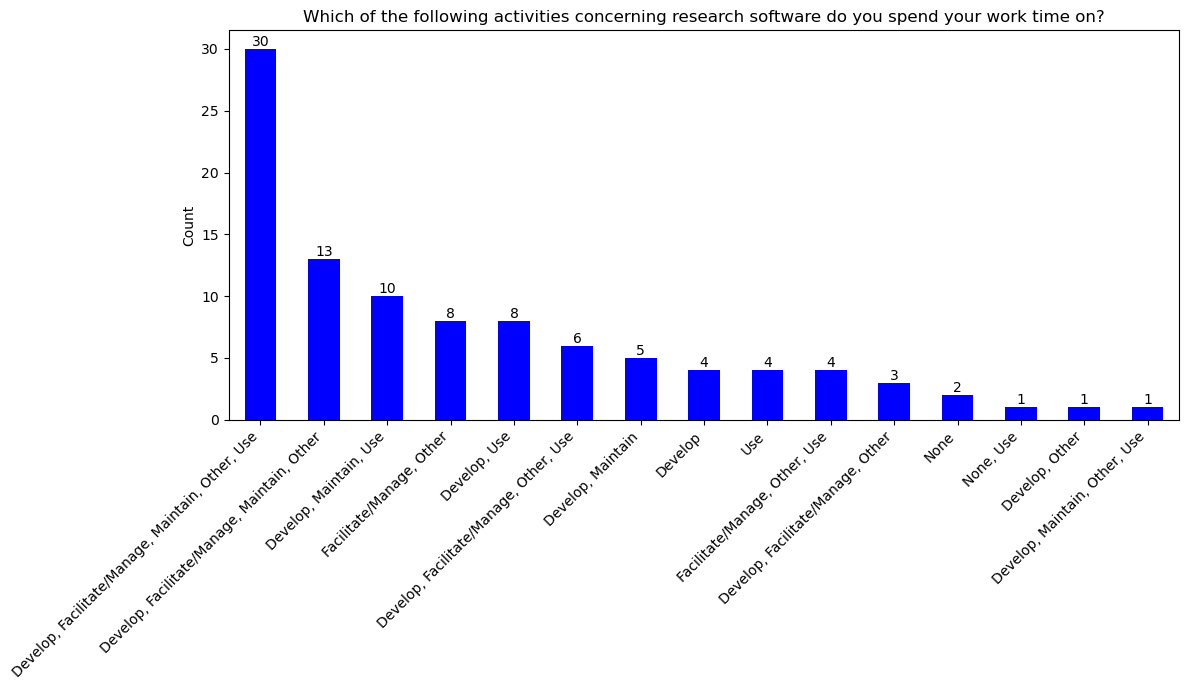

In [69]:
answer_counts= filtered_data['Question 4 Simplified'].value_counts()


plt.figure(figsize=(12, 7))
answer_counts.plot(kind='bar', color='blue')
#plt.xlabel('Answer')
plt.ylabel('Count')
plt.title('Which of the following activities concerning research software do you spend your work time on?')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
for index, value in enumerate(answer_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

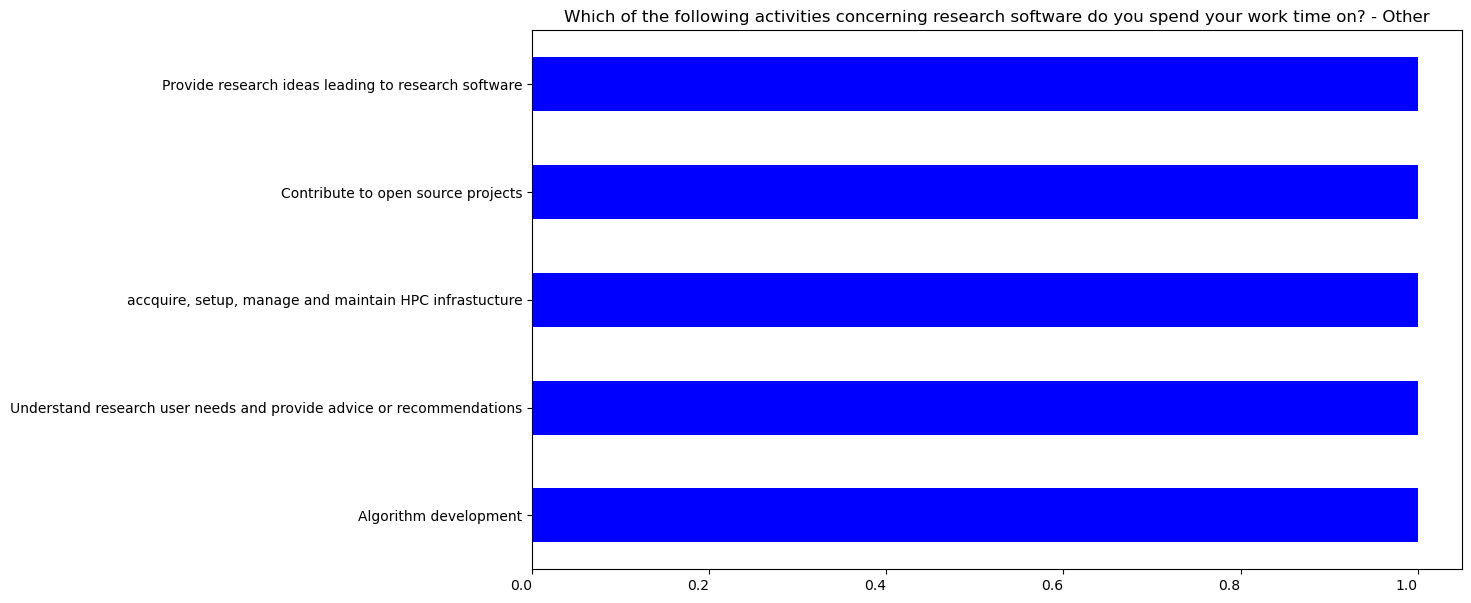

In [70]:
answer_counts=filtered_data['Question 4 - Text entry'].dropna().value_counts()

plt.figure(figsize=(12, 7))
answer_counts.plot(kind='barh', color='blue')
#plt.xlabel('Answer')
#plt.ylabel('Count')
plt.title('Which of the following activities concerning research software do you spend your work time on? - Other')
plt.xticks(rotation=0, ha='right')  # Rotate x-axis labels to make them readable

# Add counts on the plot
#for index, value in enumerate(answer_counts):
#    plt.text(index, value, str(value), ha='center', va='bottom')

#plt.tight_layout()
plt.show()

## Question 5

In [104]:
# Load the survey data from the Excel file
file_path = 'question_5.xlsx'
q5_data = pd.read_excel(file_path, index_col=False)
#survey_data = pd.read_excel(file_path)

In [105]:
q5_data.columns

Index(['Summary of What percentage of your work time do you spend working with research software?',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'],
      dtype='object')

In [106]:
len(survey_data)

100

In [107]:
q5_data

Summary of What percentage of your work time do you spend working with research software?  \
0                        FILTER: Finished equals True                                          
1                                                 NaN                                          
2                                                 NaN                                          
3                                            Variable                                          
4                                               Other                                          
5                          Maintain research software                                          
6                   Use it as part of my own research                                          
7         Facilitate others or manage others to do so                                          
8                          Develop  research software                                          
9                                                None                                          
10                                              Total                                          

   Unnamed: 1 Unnamed: 2 Unnamed: 3  
0         NaN        NaN        NaN  
1         NaN        NaN        NaN  
2         NaN        NaN        NaN  
3       Count    Average     Median  
4           5       14.8          3  
5          59  16.491525         10  
6          63  26.222222         20  
7          64  26.546875         20  
8          81  30.925926         28  
9           0        NaN        NaN  
10        272  25.378676         20

In [112]:
q5_data.iloc[4:10,0:2]

Summary of What percentage of your work time do you spend working with research software?  \
4                                              Other                                          
5                         Maintain research software                                          
6                  Use it as part of my own research                                          
7        Facilitate others or manage others to do so                                          
8                         Develop  research software                                          
9                                               None                                          

  Unnamed: 1  
4          5  
5         59  
6         63  
7         64  
8         81  
9          0

In [113]:
# Flatten the multi-level header
q5_data.columns = [' '.join(col).strip() for col in q5_data.columns.values]

In [114]:
q5_data.iloc[4:10,0:2]

S u m m a r y   o f   W h a t   p e r c e n t a g e   o f   y o u r   w o r k   t i m e   d o   y o u   s p e n d   w o r k i n g   w i t h   r e s e a r c h   s o f t w a r e ?  \
4                                              Other                                                                                                                                  
5                         Maintain research software                                                                                                                                  
6                  Use it as part of my own research                                                                                                                                  
7        Facilitate others or manage others to do so                                                                                                                                  
8                         Develop  research software                                                                                                                                  
9                                               None                                                                                                                                  

  U n n a m e d :   1  
4                   5  
5                  59  
6                  63  
7                  64  
8                  81  
9                   0

In [117]:
q5_data.columns

Index(['S u m m a r y   o f   W h a t   p e r c e n t a g e   o f   y o u r   w o r k   t i m e   d o   y o u   s p e n d   w o r k i n g   w i t h   r e s e a r c h   s o f t w a r e ?',
       'U n n a m e d :   1', 'U n n a m e d :   2', 'U n n a m e d :   3'],
      dtype='object')

In [118]:
# Create a dictionary to rename columns

rename_dict = {
    'S u m m a r y   o f   W h a t   p e r c e n t a g e   o f   y o u r   w o r k   t i m e   d o   y o u   s p e n d   w o r k i n g   w i t h   r e s e a r c h   s o f t w a r e ?': 
    'Activity',
    'U n n a m e d :   1':
    'Count',
    
}

# Rename columns in the DataFrame
q5_data.rename(columns=rename_dict, inplace=True)

# Display the new column names to verify the renaming
q5_data.columns

Index(['Activity', 'Count', 'U n n a m e d :   2', 'U n n a m e d :   3'], dtype='object')

In [119]:
q5_data.iloc[4:10,0:2]

Activity Count
4                                        Other     5
5                   Maintain research software    59
6            Use it as part of my own research    63
7  Facilitate others or manage others to do so    64
8                   Develop  research software    81
9                                         None     0

In [120]:
q5_data= q5_data.reset_index(drop=True)

In [121]:
q5_data.reset_index(drop=True)

Activity  Count U n n a m e d :   2  \
0                  FILTER: Finished equals True    NaN                 NaN   
1                                           NaN    NaN                 NaN   
2                                           NaN    NaN                 NaN   
3                                      Variable  Count             Average   
4                                         Other      5                14.8   
5                    Maintain research software     59           16.491525   
6             Use it as part of my own research     63           26.222222   
7   Facilitate others or manage others to do so     64           26.546875   
8                    Develop  research software     81           30.925926   
9                                          None      0                 NaN   
10                                        Total    272           25.378676   

   U n n a m e d :   3  
0                  NaN  
1                  NaN  
2                  NaN  
3               Median  
4                    3  
5                   10  
6                   20  
7                   20  
8                   28  
9                  NaN  
10                  20

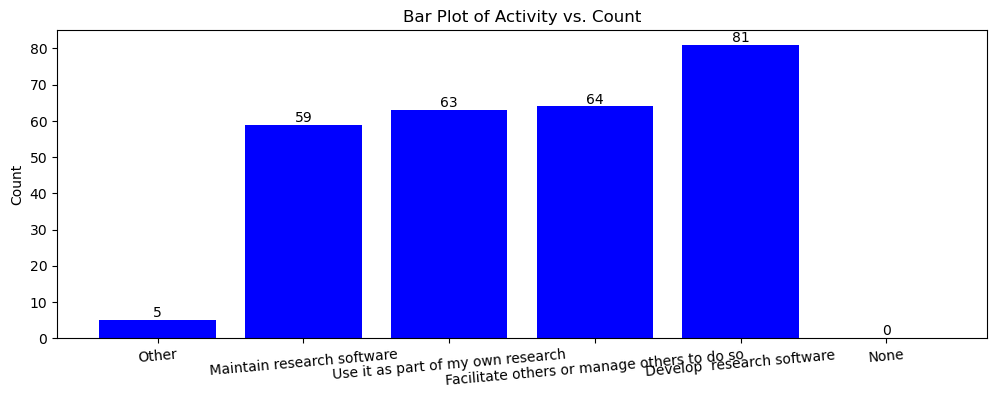

In [126]:
subset = q5_data.iloc[4:10, 0:2]

plt.figure(figsize=(12, 4))
bars = plt.bar(subset['Activity'], subset['Count'], color='blue')

# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

#plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=5)
plt.title('Bar Plot of Activity vs. Count')
plt.show()

In [127]:
# Create a dictionary to rename columns

rename_dict = {
    'Q5_1 What percentage of your work time do you spend working with research software? - Develop  research software': 
    'Q5-Develop  research software ',
       'Q5_2 What percentage of your work time do you spend working with research software? - Maintain research software': 
    'Q5-Maintain research software',
       'Q5_3 What percentage of your work time do you spend working with research software? - Facilitate others or manage others to do so': 
    'Q5-Facilitate others or manage others',
       'Q5_4 What percentage of your work time do you spend working with research software? - Use it as part of my own research':
    'Q5-Use it as part of my own research',
       'Q5_5 What percentage of your work time do you spend working with research software? - Other':
    'Q5-Other',
       'Q5_6 What percentage of your work time do you spend working with research software? - None':
    'Q5-None',
       'Q5_5_TEXT What percentage of your work time do you spend working with research software? - Other - Text':
    'Q5-Text'
    
}

# Rename columns in the DataFrame
survey_data.rename(columns=rename_dict, inplace=True)

# Display the new column names to verify the renaming
survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [128]:
names=['Q5-Develop  research software ',
       'Q5-Maintain research software',
       'Q5-Facilitate others or manage others',
       'Q5-Use it as part of my own research', 'Q5-Other', 'Q5-None',
       'Q5-Text']
survey_data[names]

Q5-Develop  research software   Q5-Maintain research software  \
0                             19.0                           12.0   
1                              NaN                            NaN   
2                             60.0                            NaN   
3                              NaN                            NaN   
4                             81.0                            NaN   
..                             ...                            ...   
95                            40.0                           10.0   
96                            25.0                           10.0   
97                             1.0                            1.0   
98                             NaN                            NaN   
99                             5.0                            2.0   

    Q5-Facilitate others or manage others  \
0                                     NaN   
1                                    34.0   
2                                    10.0   
3                                     0.0   
4                                    18.0   
..                                    ...   
95                                    NaN   
96                                   15.0   
97                                    NaN   
98                                   10.0   
99                                   50.0   

    Q5-Use it as part of my own research  Q5-Other  Q5-None Q5-Text  
0                                   71.0       NaN      NaN     NaN  
1                                    NaN       NaN      NaN     NaN  
2                                   10.0       NaN      NaN     NaN  
3                                    NaN       NaN      NaN     NaN  
4                                    NaN       NaN      NaN     NaN  
..                                   ...       ...      ...     ...  
95                                  50.0       NaN      NaN     NaN  
96                                  50.0       NaN      NaN     NaN  
97                                   5.0       NaN      NaN     NaN  
98                                   9.0       NaN      NaN     NaN  
99                                  15.0       NaN      NaN     NaN  

[100 rows x 7 columns]

In [129]:
survey_data.iloc[:,47:53].sum()

Q5-Develop  research software            2505.0
Q5-Maintain research software             973.0
Q5-Facilitate others or manage others    1699.0
Q5-Use it as part of my own research     1652.0
Q5-Other                                   74.0
Q5-None                                     0.0
dtype: float64

In [130]:
survey_data[names].sum()

C:\Users\P256980\AppData\Local\Temp\ipykernel_34524\1252816726.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  survey_data[names].sum()


Q5-Develop  research software            2505.0
Q5-Maintain research software             973.0
Q5-Facilitate others or manage others    1699.0
Q5-Use it as part of my own research     1652.0
Q5-Other                                   74.0
Q5-None                                     0.0
dtype: float64

<Figure size 1200x600 with 0 Axes>

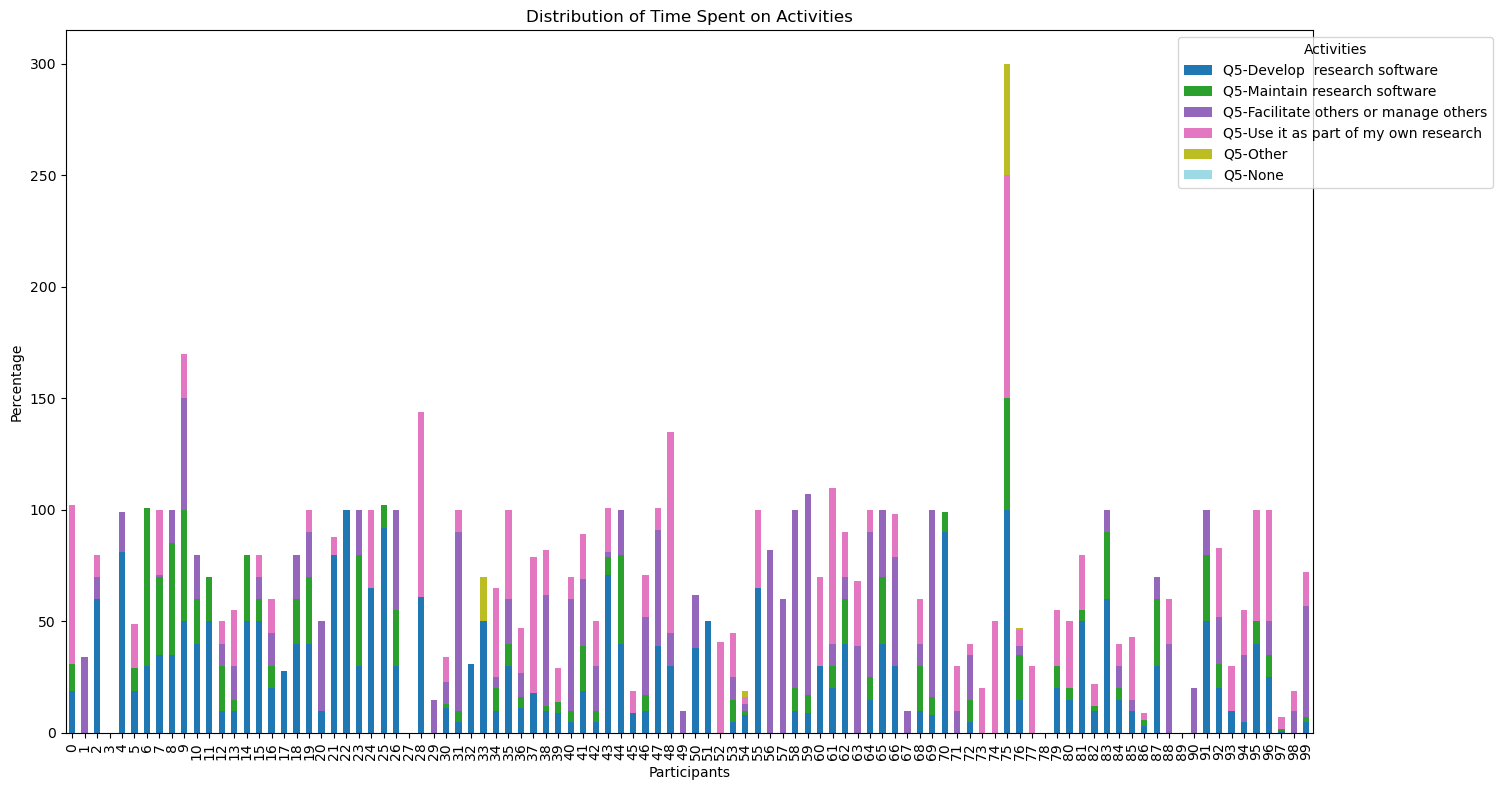

In [131]:

survey_data_numeric = survey_data.iloc[:,47:53].apply(pd.to_numeric, errors='coerce')

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
survey_data_numeric.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')

# Set titles and labels
plt.title('Distribution of Time Spent on Activities')
plt.xlabel('Participants')
plt.ylabel('Percentage')
plt.legend(title='Activities', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

# Display the plot
plt.show()

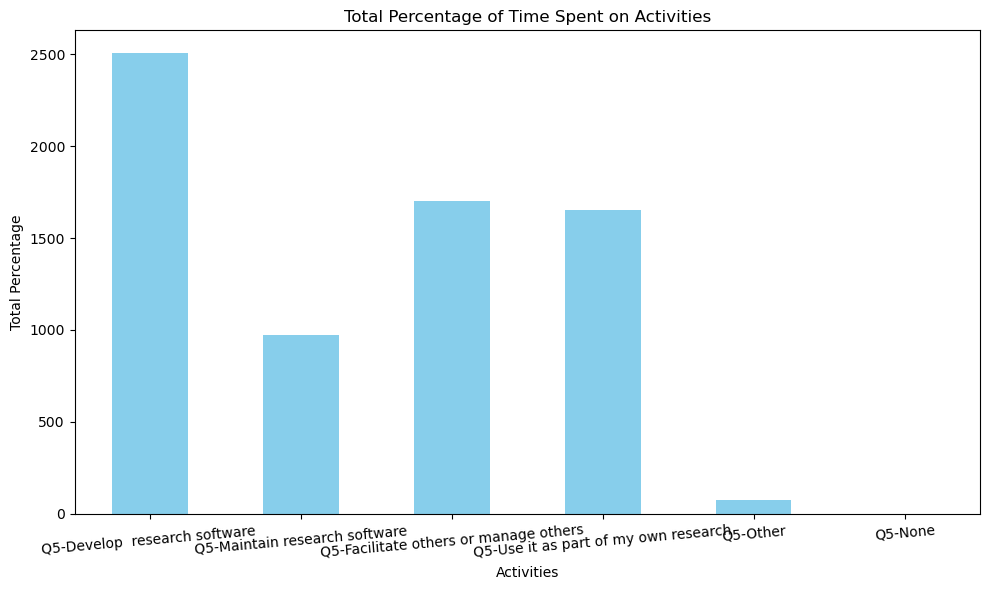

In [132]:
# Ensure all columns are numeric (ignore errors to skip non-numeric data)
survey_data_numeric = survey_data.iloc[:,47:53].apply(pd.to_numeric, errors='coerce')

# Sum percentages for each activity across all participants
activity_sums = survey_data_numeric.sum()

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
activity_sums.plot(kind='bar', stacked=True, color='skyblue')

# Set titles and labels
plt.title('Total Percentage of Time Spent on Activities')
plt.xlabel('Activities')
plt.ylabel('Total Percentage')
plt.xticks(rotation=5)
plt.tight_layout()

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

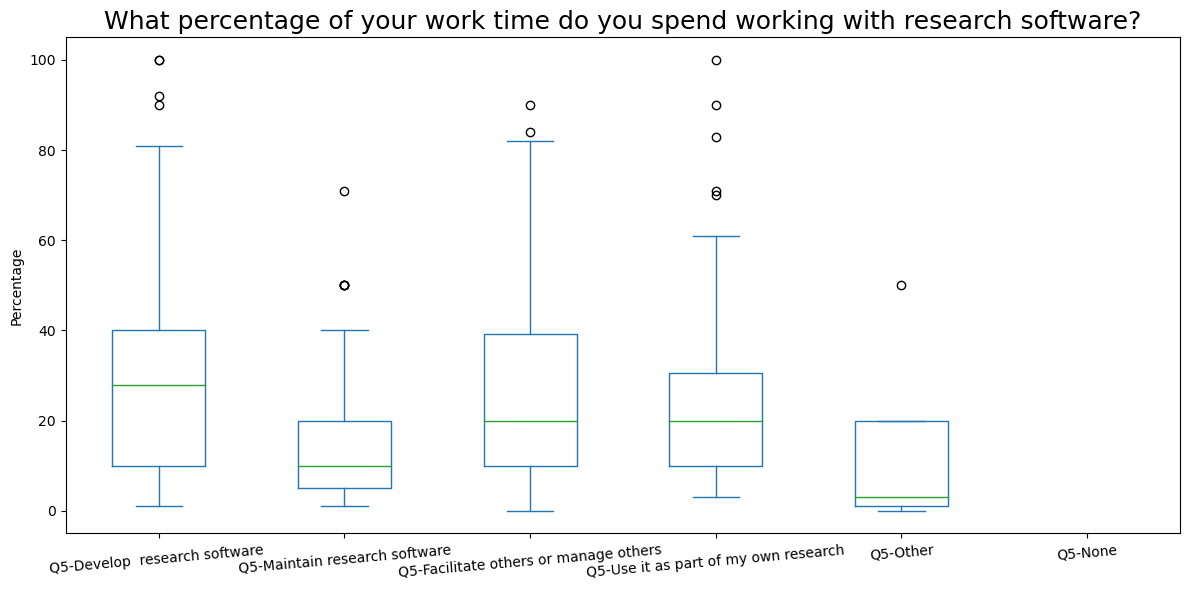

In [142]:
plt.figure(figsize=(10, 6))
survey_data_numeric.plot(kind='box', figsize=(12, 6))

# Set titles and labels
plt.title('What percentage of your work time do you spend working with research software?', fontsize=18)
#plt.xlabel('Activities')
plt.ylabel('Percentage')
plt.xticks(rotation=5)
plt.tight_layout()

# Display the plot
plt.show()

In [134]:
survey_data_numeric

Q5-Develop  research software   Q5-Maintain research software  \
0                             19.0                           12.0   
1                              NaN                            NaN   
2                             60.0                            NaN   
3                              NaN                            NaN   
4                             81.0                            NaN   
..                             ...                            ...   
95                            40.0                           10.0   
96                            25.0                           10.0   
97                             1.0                            1.0   
98                             NaN                            NaN   
99                             5.0                            2.0   

    Q5-Facilitate others or manage others  \
0                                     NaN   
1                                    34.0   
2                                    10.0   
3                                     0.0   
4                                    18.0   
..                                    ...   
95                                    NaN   
96                                   15.0   
97                                    NaN   
98                                   10.0   
99                                   50.0   

    Q5-Use it as part of my own research  Q5-Other  Q5-None  
0                                   71.0       NaN      NaN  
1                                    NaN       NaN      NaN  
2                                   10.0       NaN      NaN  
3                                    NaN       NaN      NaN  
4                                    NaN       NaN      NaN  
..                                   ...       ...      ...  
95                                  50.0       NaN      NaN  
96                                  50.0       NaN      NaN  
97                                   5.0       NaN      NaN  
98                                   9.0       NaN      NaN  
99                                  15.0       NaN      NaN  

[100 rows x 6 columns]

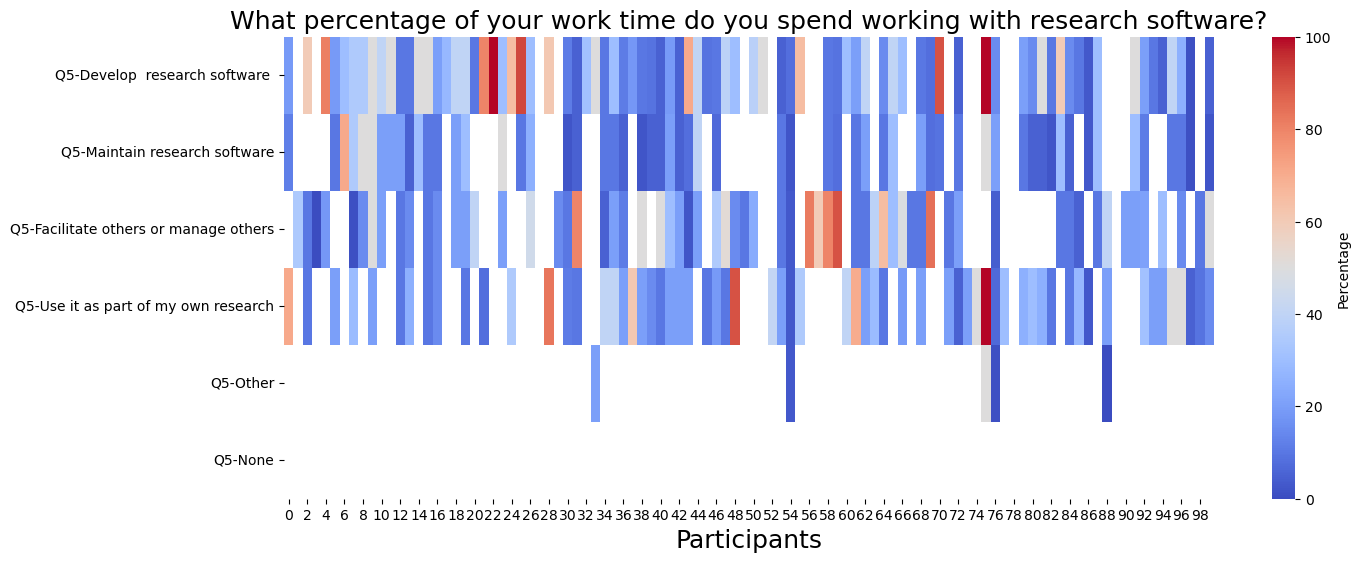

In [141]:
###### Plotting the heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(survey_data_numeric.T, cmap='coolwarm', cbar_kws={'label': 'Percentage'})

# Set titles and labels with a bigger title font size
plt.title('What percentage of your work time do you spend working with research software?', fontsize=18)
plt.xlabel('Participants',fontsize=18)
#plt.ylabel('Activities')
#plt.tight_layout()

# Display the plot
plt.show()


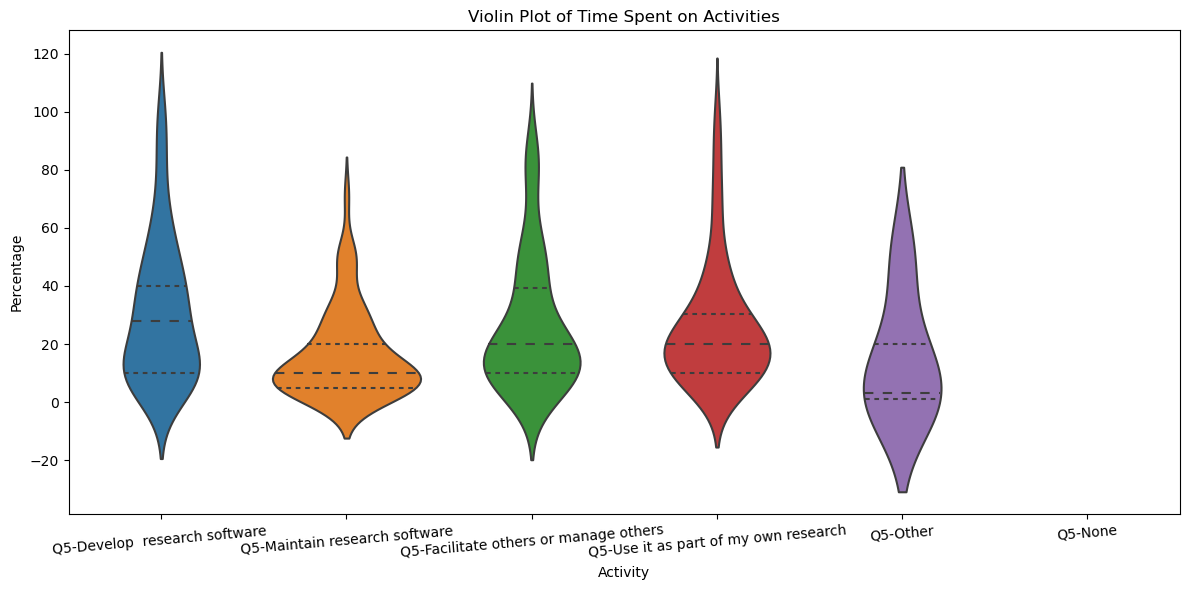

In [222]:
# Convert to long format for violin plot
survey_data_melted = survey_data_numeric.melt(var_name='Activity', value_name='Percentage')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Activity', y='Percentage', data=survey_data_melted, inner='quartile')

# Set titles and labels
plt.title('Violin Plot of Time Spent on Activities')
#plt.xlabel('Activities')
plt.ylabel('Percentage')
plt.xticks(rotation=5)
plt.tight_layout()

# Display the plot
plt.show()

# Question 6

In [247]:
# Load the survey data from the Excel file
file_path = 'question_6.xlsx'
q6_data = pd.read_excel(file_path, index_col=False)
q6_data.head()

Summary of Regarding the research software you indicated you work with: Is this software developed solely for use in the research of the person who develops it ? (This person could be you.) Or is it intended for a research group or community?  \
0                       FILTER: Finished equals True                                                                                                                                                                                                   
1                                                NaN                                                                                                                                                                                                   
2                                                NaN                                                                                                                                                                                                   
3                                Categorical Summary                                                                                                                                                                                                   
4                                                NaN                                                                                                                                                                                                   

  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN

In [246]:
q6_data.columns

Index(['Summary of Regarding the research software you indicated you work with: Is this software developed solely for use in the research of the person who develops it ? (This person could be you.) Or is it intended for a research group or community?',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],
      dtype='object')

In [249]:
# Create a dictionary to rename columns

rename_dict = {
    'Summary of Regarding the research software you indicated you work with: Is this software developed solely for use in the research of the person who develops it ? (This person could be you.) Or is it intended for a research group or community?': 
    'Activity',
    'Unnamed: 1':
    'Count',
    
}

# Rename columns in the DataFrame
q6_data.rename(columns=rename_dict, inplace=True)

# Display the new column names to verify the renaming
q6_data.columns

Index(['Activity', 'Count', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [255]:
q6_data.iloc[9:12,0:2]

Activity Count
9                        Personal use     6
10  For a research group or community    50
11                               Both    41

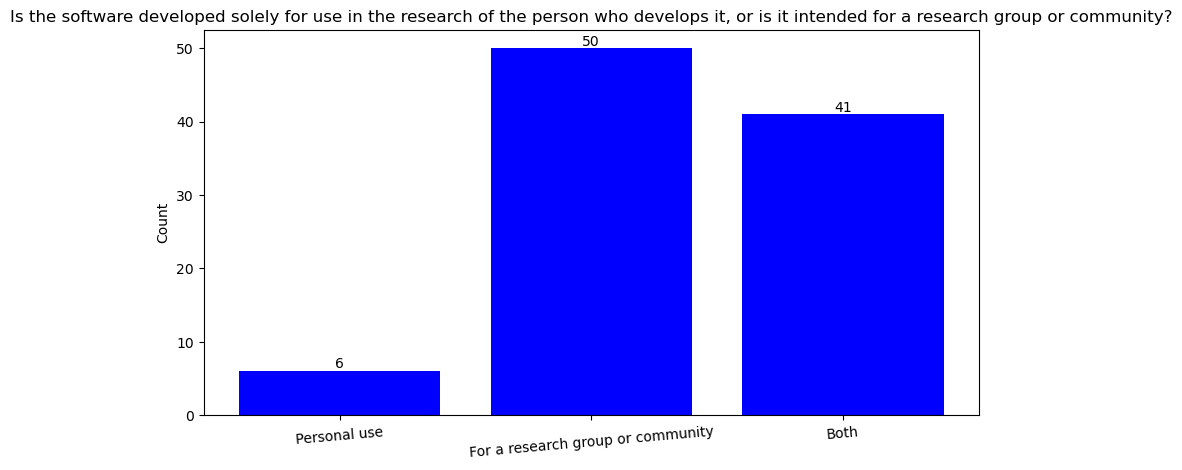

In [259]:
subset = q6_data.iloc[9:12, 0:2]

plt.figure(figsize=(10, 5))
bars = plt.bar(subset['Activity'], subset['Count'], color='blue')

# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

#plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=5)
plt.title('Is the software developed solely for use in the research of the person who develops it, or is it intended for a research group or community?')
plt.show()


# Question 7

In [143]:
survey_data['Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice']

0                                  T3: Specific Methods
1                                  T3: Specific Methods
2     T1: Contribution to Community,T2: Core Infrast...
3                               T2: Core Infrastructure
4     T1: Contribution to Community,T2: Core Infrast...
                            ...                        
95                                 T3: Specific Methods
96    T1: Contribution to Community,T2: Core Infrast...
97    T1: Contribution to Community,T3: Specific Met...
98    T1: Contribution to Community,T2: Core Infrast...
99    T1: Contribution to Community,T3: Specific Met...
Name: Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services

In [144]:
survey_data.iloc[:,7:8]

Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice
0                                T3: Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                                T3: Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2   T1: Contribution to Community,T2: Core Infrast...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
3                             T2: Core Infrastructure                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [145]:
# Define the replacements dictionary
replacements = {
    'T3: Specific Methods': 'Specific Methods',
    'T1: Contribution to Community,T2: Core Infrastructure': 'Contribution to Community & Core Infrastructure',
    'T2: Core Infrastructure': 'Core Infrastructure',
    'T1: Contribution to Community,T2: Core Infrastructure,T3: Specific Methods': 
    'Contribution to Community & Core Infrastructure & Specific Methods',
    'T1: Contribution to Community,T3: Specific Methods': 'Contribution to Community & Specific Methods',
    'T2: Core Infrastructure,T3: Specific Methods': 'Core Infrastructure & Specific Methods',
    'T1: Contribution to Community': 'Contribution to Community',
    'T1: Contribution to Community,Other (please specify):': 'Contribution to Community & Other',
    'Other (please specify):': 'Other',
    

}

# Apply the replacements to the 'Question 1' column
survey_data= survey_data.replace(replacements)

In [146]:
# Display the DataFrame to check the results
survey_data.iloc[:,7:8]

Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice
0                                    Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                                    Specific Methods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2     Contribution to Community & Core Infrastructure                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
3                                 Core Infrastructure                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [147]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice': 
    'Question_7'
}, inplace=True)

In [148]:
survey_data.iloc[:,7:8].stack().unique()

array(['Specific Methods',
       'Contribution to Community & Core Infrastructure',
       'Core Infrastructure',
       'Contribution to Community & Core Infrastructure & Specific Methods',
       'Contribution to Community & Specific Methods',
       'Core Infrastructure & Specific Methods',
       'Contribution to Community', 'Contribution to Community & Other',
       'Other'], dtype=object)

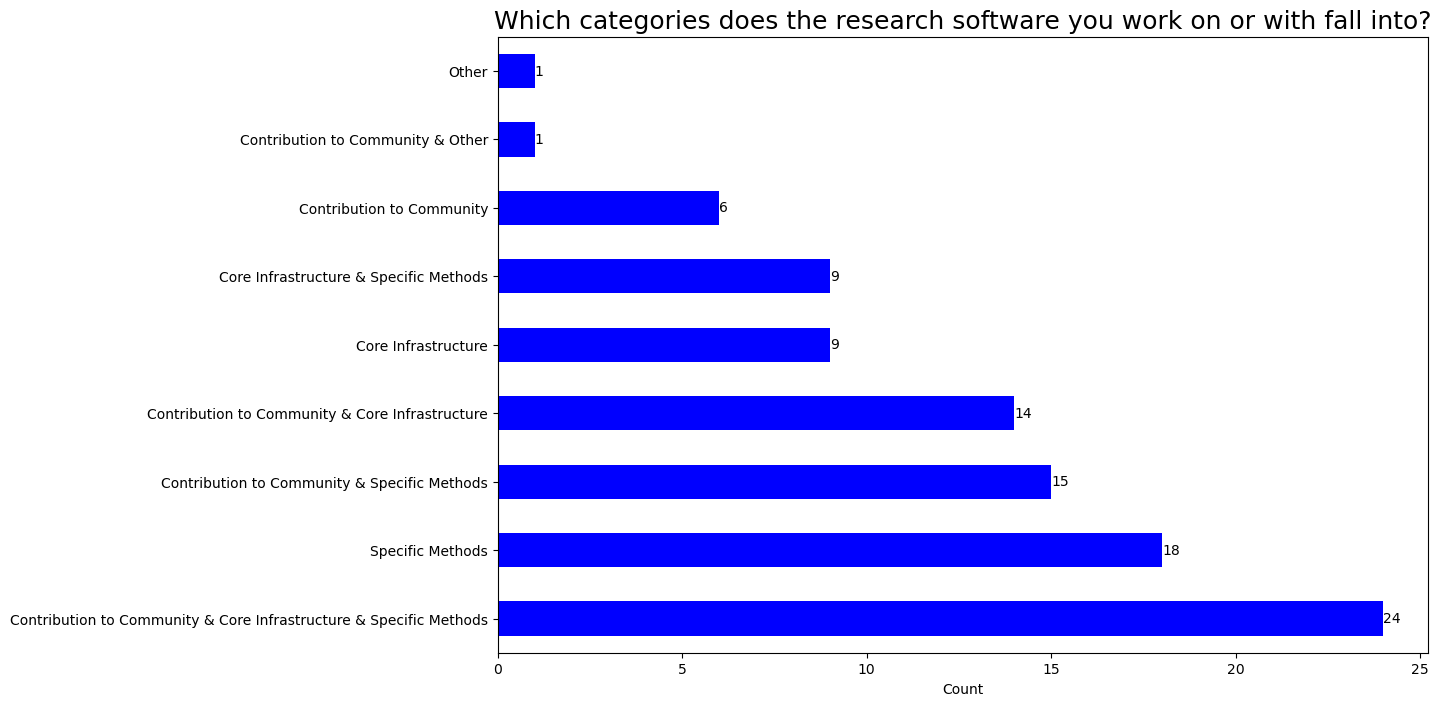

In [153]:
answer_counts = survey_data['Question_7'].value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
ax = answer_counts.plot(kind='barh', color='blue')

# Add labels and title
plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('Which categories does the research software you work on or with fall into?', fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=10)

plt.show()

# Question 8

In [287]:
survey_data['Q8 What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice']

0      I am doing research and as part of the researc...
1      I am doing research and as part of the researc...
2      I am doing research and as part of the researc...
3      I am the PI, co-PI, supervisor or manager on a...
4      I am not doing research but I am writing resea...
                             ...                        
192    I am doing research and as part of the researc...
193                                                  NaN
194                                                  NaN
195                                                  NaN
196    I am doing research and as part of the researc...
Name: Q8 What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice, Length: 197, dtype: object

In [293]:
# Define the replacements dictionary for renaming columns
replacements = {
    'Q8 What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice': 
    'Question 8',
    'Q8_8_TEXT What is your role related to the research software you work with? (More than one option can be selected) - Other (please specify): - Text': 
    'Question 8-Text'
}
# Apply the replacements to the column names
survey_data = survey_data.rename(columns=replacements)

# Display the updated column names
print(survey_data.columns)


Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [295]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_8_finished = survey_data.loc[survey_data['Finished'] == True, 'Question 8']

# Display the result
print(len(question_8_finished))


100


In [296]:
question_8_finished.value_counts()

I am not doing research but I am writing research software.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       14
I am doing research and as part of the research I am developing research software.,I am doing research and as part of the research I am using research software.,I am doing research and as part of the research I am maintaining research software.                                                                                                                                                                                                                               

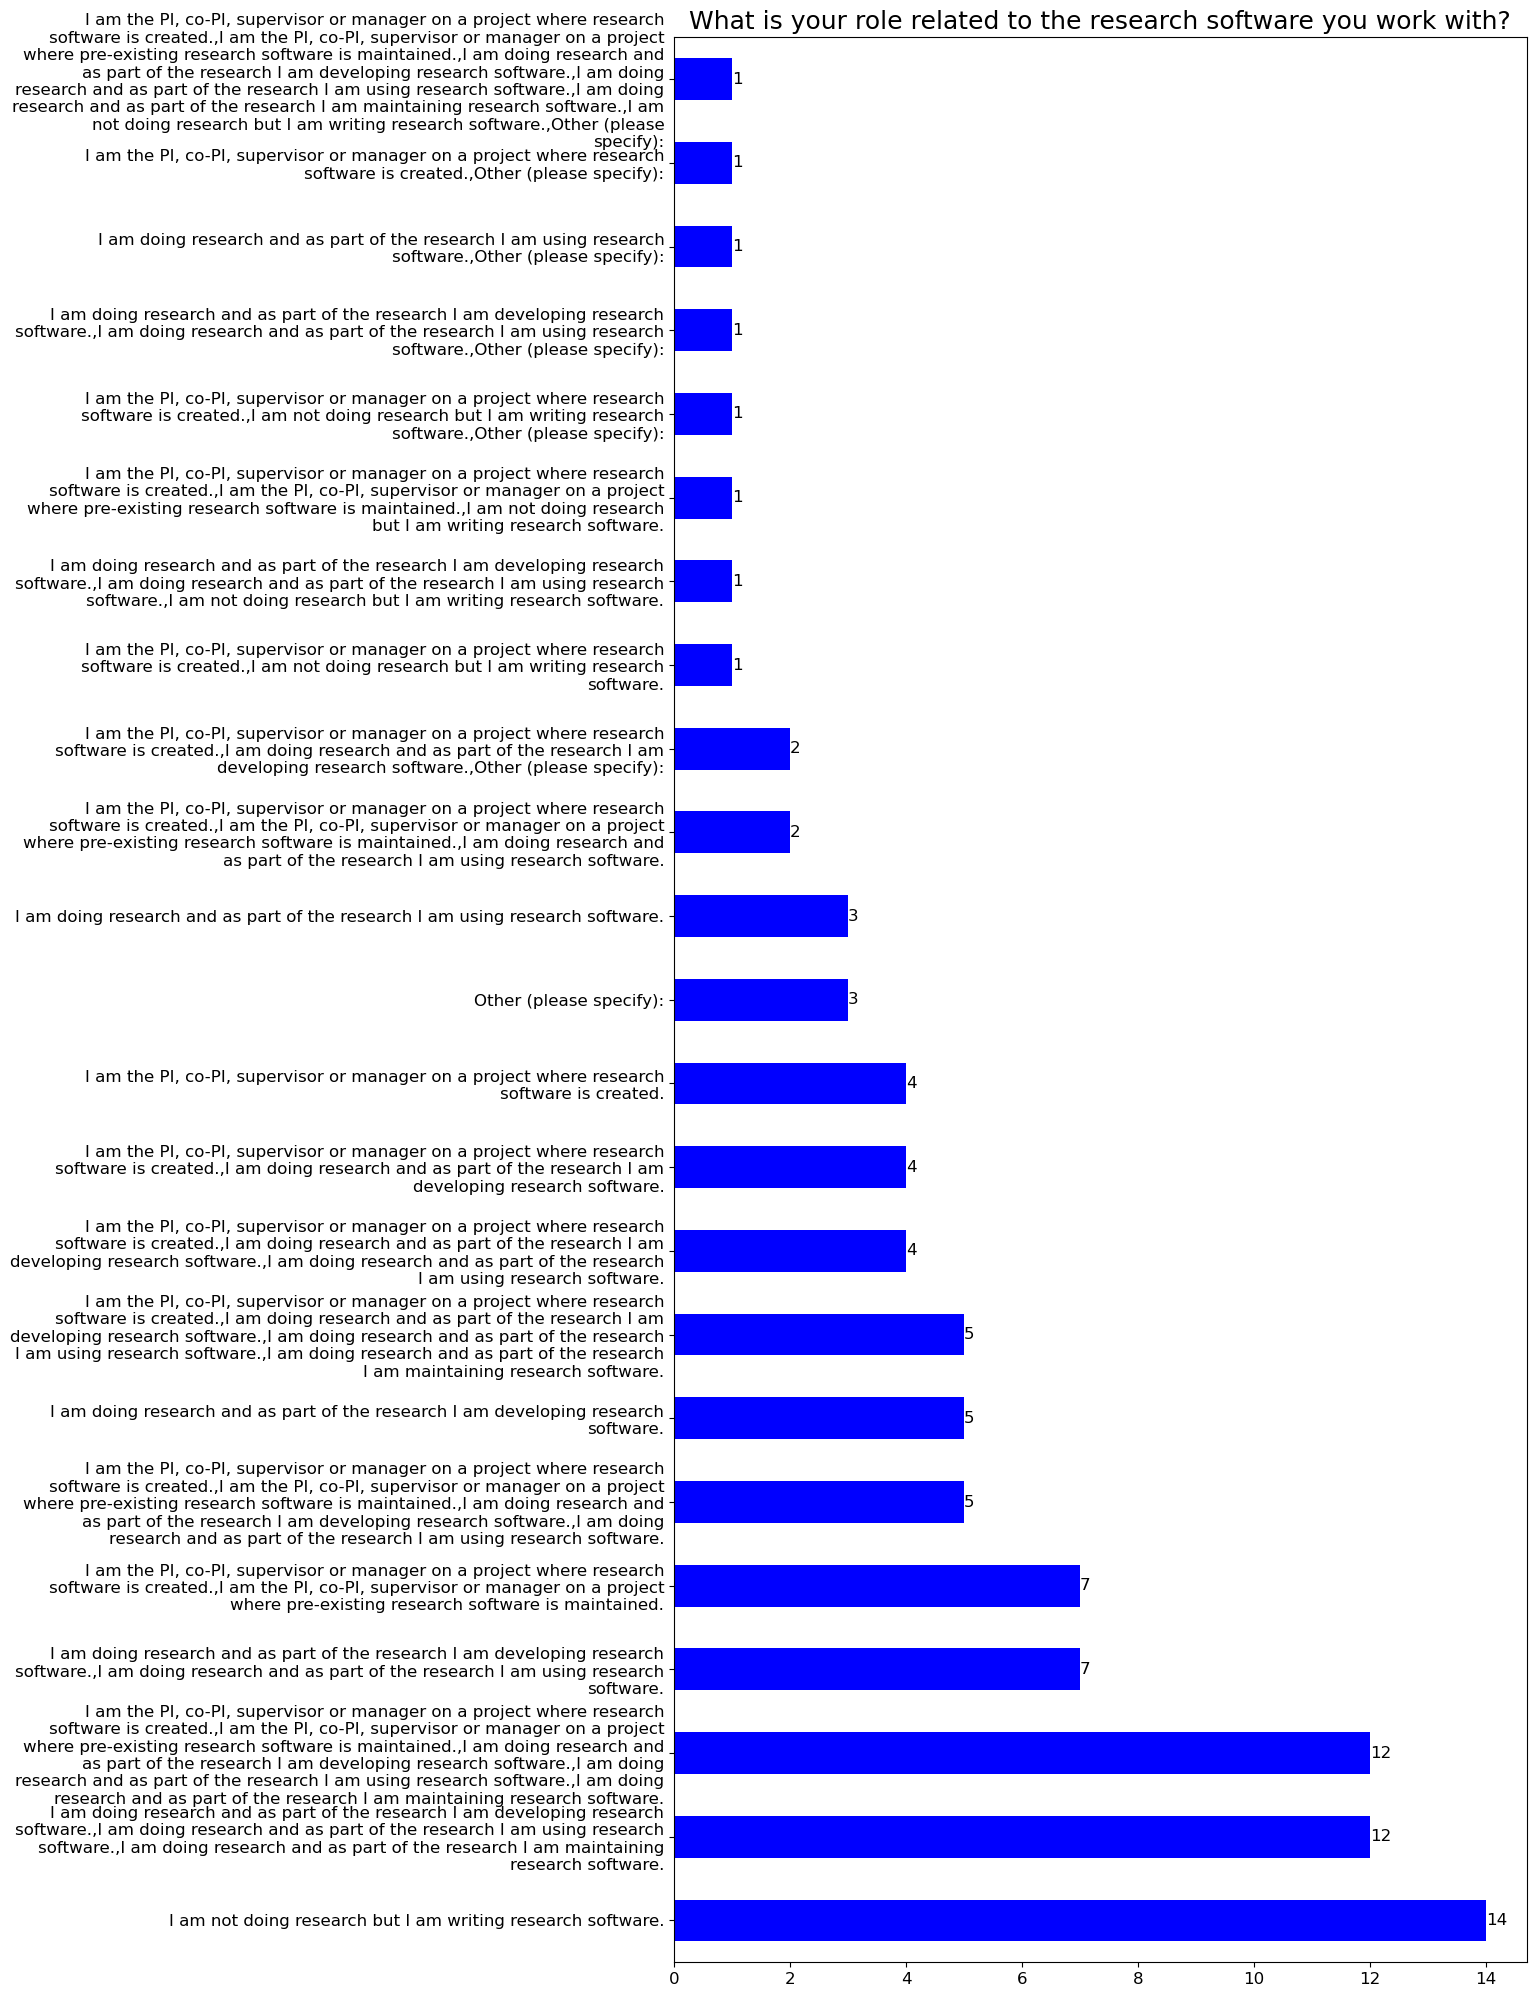

In [310]:
answer_counts= question_8_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 77  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(11, 25))
ax = answer_counts.plot(kind='barh', color='blue',fontsize=12)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('What is your role related to the research software you work with?', fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=12)

plt.show()

In [311]:
# Load the survey data from the Excel file
file_path = 'question_8.xlsx'
q8_data = pd.read_excel(file_path, index_col=False)
q8_data.head()

Summary of What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice  \
0                       FILTER: Finished equals True                                                                                      
1                                                NaN                                                                                      
2                                                NaN                                                                                      
3                                Categorical Summary                                                                                      
4                                                NaN                                                                                      

  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN

In [260]:
q8_data.columns

Index(['Summary of What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],
      dtype='object')

In [329]:
# Create a dictionary to rename columns

rename_dict = {
    'Summary of What is your role related to the research software you work with? (More than one option can be selected) - Selected Choice': 
    'Activity',
    'Unnamed: 3':
    'Count',
}

# Rename columns in the DataFrame
q8_data.rename(columns=rename_dict, inplace=True)

# Display the new column names to verify the renaming
q8_data.columns

Index(['Activity', 'Unnamed: 1', 'Unnamed: 2', 'Count', 'Unnamed: 4'], dtype='object')

In [330]:
q8_data.columns

Index(['Activity', 'Unnamed: 1', 'Unnamed: 2', 'Count', 'Unnamed: 4'], dtype='object')

In [334]:
len(q8_data)

28

In [339]:
 q8_data[['Activity', 'Count']].iloc[6:13,0:2]

Activity Count
6   I am doing research and as part of the researc...    59
7   I am doing research and as part of the researc...    54
8   I am the PI, co-PI, supervisor or manager on a...    50
9   I am doing research and as part of the researc...    30
10  I am the PI, co-PI, supervisor or manager on a...    28
11  I am not doing research but I am writing resea...    19
12                            Other (please specify):    10

C:\Users\P256980\AppData\Local\Temp\ipykernel_34524\488053903.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=13)


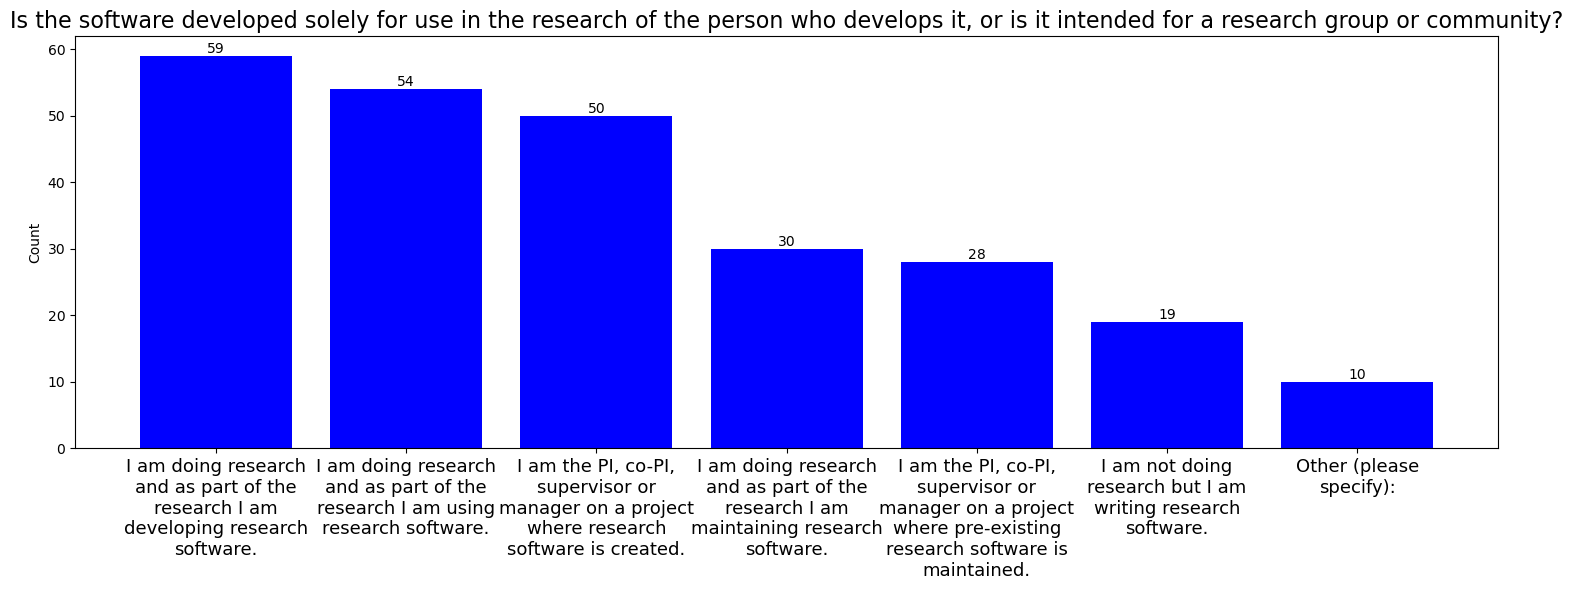

In [356]:
# Subset the data
subset = q8_data[['Activity', 'Count']].iloc[6:13, 0:2]

# Set the maximum width for each line of text in the x-axis labels
max_width = 20  # Adjust this width based on your preference

# Wrap the long text in the x-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in subset['Activity']]

plt.figure(figsize=(15, 6))
bars = plt.bar(subset['Activity'], subset['Count'], color='blue')

# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.ylabel('Count')

# Get the current axes
ax = plt.gca()

# Set the wrapped labels as x-tick labels
ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=13)

plt.title('Is the software developed solely for use in the research of the person who develops it, or is it intended for a research group or community?', fontsize=16)
plt.tight_layout()
plt.show()


# Question 9

In [154]:
# Load the survey data from the Excel file
file_path = 'question_9.xlsx'
q9_data = pd.read_excel(file_path, index_col=False)


In [155]:
q9_data.iloc[9:16:,0:2]

Summary of Is the research software you work with developed in a specific project? If so, do you know how this project is funded? (If you work on multiple pieces of research software, please answer this question for the project you spend most of your time on). - Selected Choice  \
9                              Not part of a project.                                                                                                                                                                                                                                       
10  Part of a project but I do not know if/how it ...                                                                                                                                                                                                                                       
11              Part of a project that is not funded.                                                                                                                                                                                                                                       
12      Part of a project that is funded through NWO.                                                                                                                                                                                                                                       
13  Part of a project that is funded through EU re...                                                                                                                                                                                                                                       
14  Part of a project that is funded through the e...                                                                                                                                                                                                                                       
15  Part of a project that is funded through other...                                                                                                                                                                                                                                       

   Unnamed: 1  
9          20  
10          9  
11          5  
12         14  
13         12  
14         10  
15         27

In [156]:
q9_data.columns

Index(['Summary of Is the research software you work with developed in a specific project? If so, do you know how this project is funded? (If you work on multiple pieces of research software, please answer this question for the project you spend most of your time on). - Selected Choice',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],
      dtype='object')

In [157]:
# Rename column with a long name to a shorter, more manageable name
q9_data.rename(columns={
'Summary of Is the research software you work with developed in a specific project? If so, do you know how this project is funded? (If you work on multiple pieces of research software, please answer this question for the project you spend most of your time on). - Selected Choice': 
'Question_9'
}, inplace=True)

In [158]:
# Rename column with a long name to a shorter, more manageable name
q9_data.rename(columns={
'Unnamed: 1': 
'Count'
}, inplace=True)

In [159]:
q9_data.iloc[9:16,0:2].stack().unique()

array(['Not part of a project.', 20,
       'Part of a project but I do not know if/how it is funded.', 9,
       'Part of a project that is not funded.', 5,
       'Part of a project that is funded through NWO.', 14,
       'Part of a project that is funded through EU research fund.', 12,
       'Part of a project that is funded through the eScience Center.',
       10,
       'Part of a project that is funded through other means: (please specify)',
       27], dtype=object)

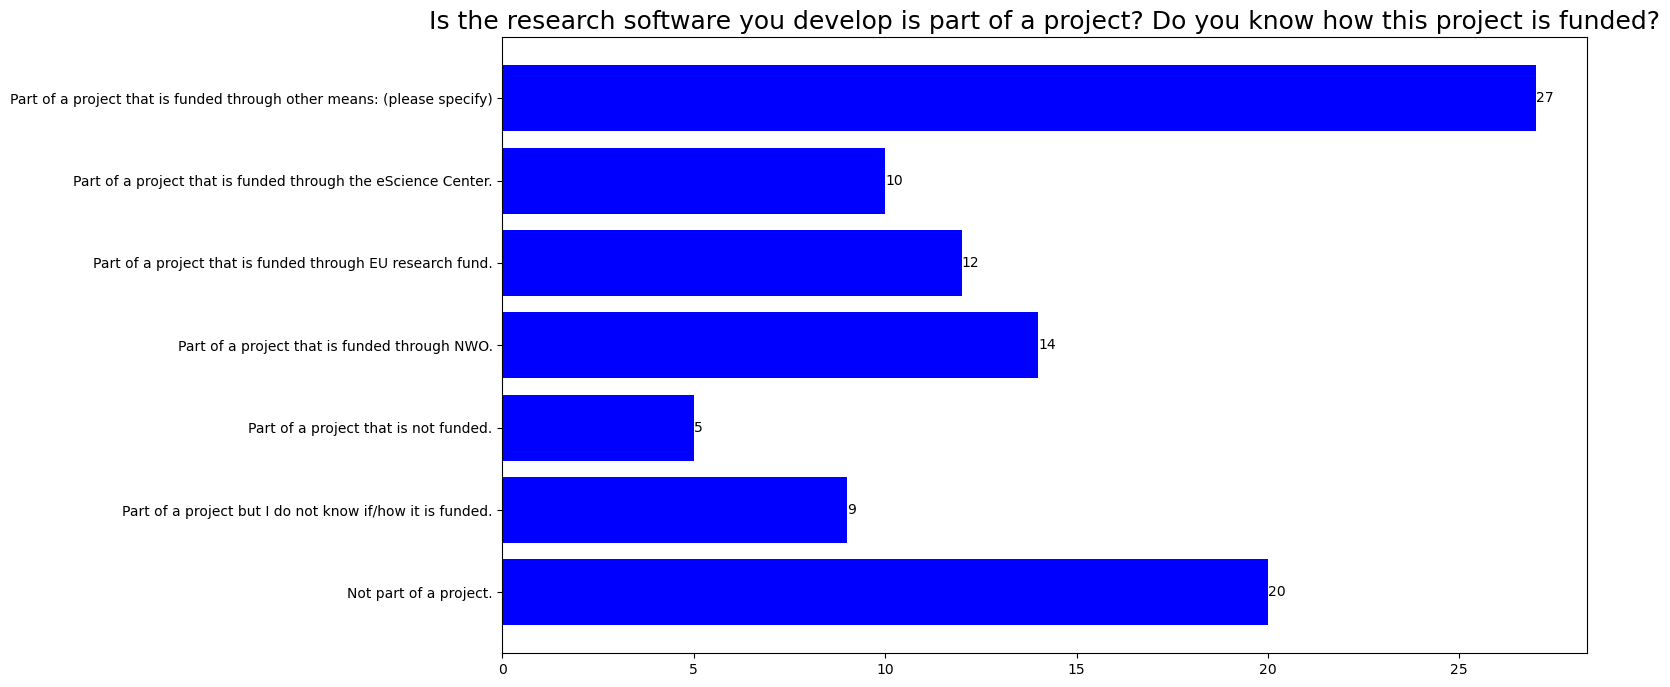

In [162]:
subset = q9_data.iloc[9:16, 0:2]

plt.figure(figsize=(14, 8))
bars = plt.barh(subset['Question_9'], subset['Count'], color='blue')

plt.title('Is the research software you develop is part of a project? Do you know how this project is funded?', fontsize=18)

# Display counts on bars
for bar in bars:
    # Get the width (i.e., the count) of each bar
    count = bar.get_width()
    # Place the text at the end of each bar
    plt.text(count, bar.get_y() + bar.get_height() / 2, f'{int(count):,}', va='center', ha='left', fontsize=10, color='black')
    
plt.show()

### Follow-up plots 

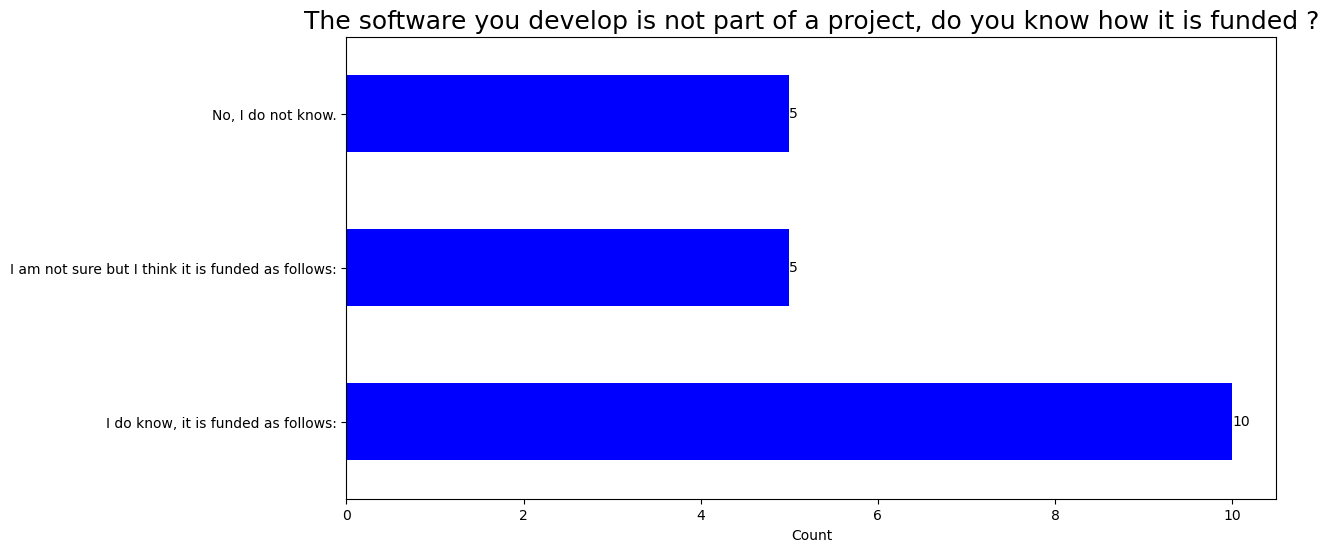

In [166]:
answer_counts= survey_data['Q9.1 Do you know how your work with research software is funded? - Selected Choice'].value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(12, 6))
ax = answer_counts.plot(kind='barh', color='blue')

# Add labels and title
plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('The software you develop is not part of a project, do you know how it is funded ?',fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=10)

plt.show()

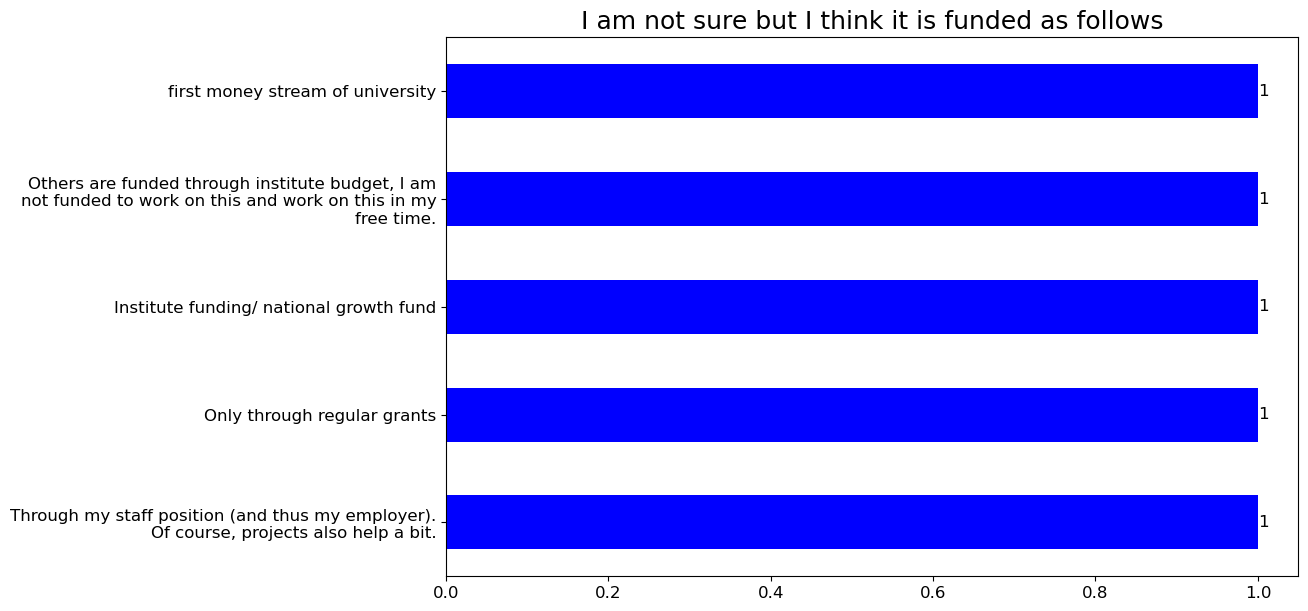

In [241]:
answer_counts= survey_data['Q9.1_2_TEXT Do you know how your work with research software is funded? - I am not sure but I think it is funded as follows: - Text'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(11, 7))
ax = answer_counts.plot(kind='barh', color='blue',fontsize=12)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('I am not sure but I think it is funded as follows', fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=12)

plt.show()

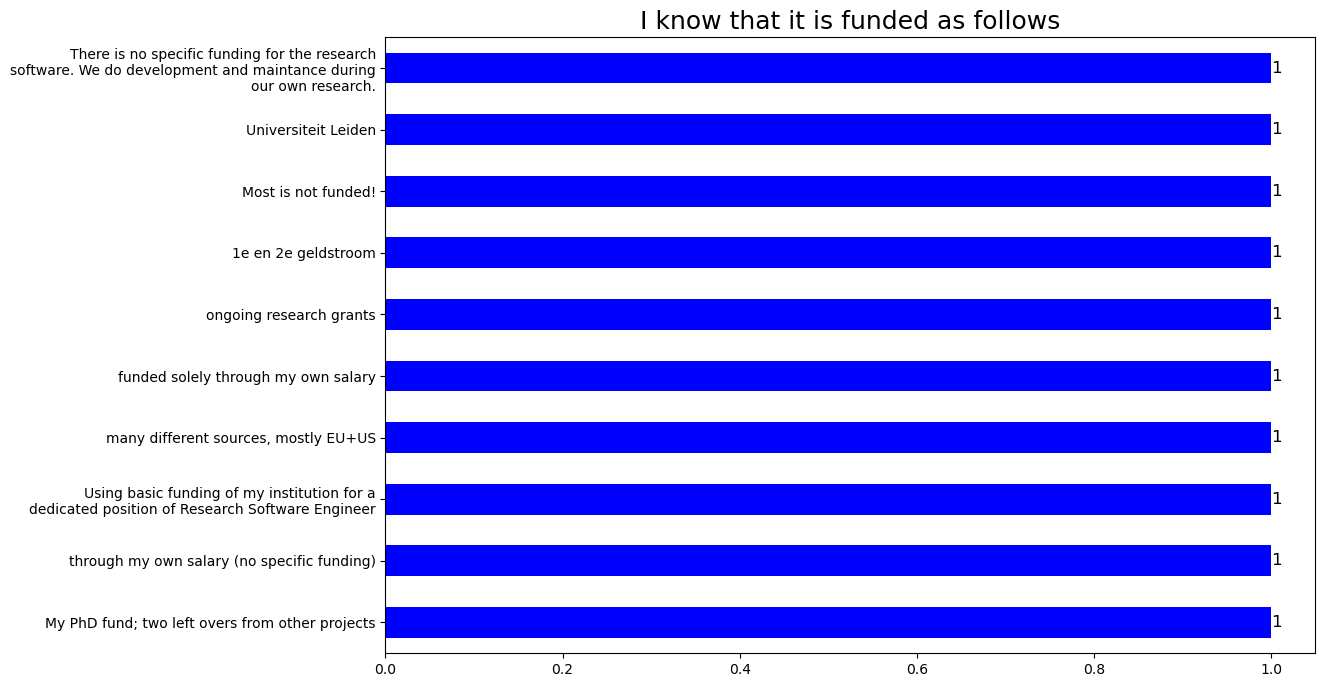

In [237]:
answer_counts= survey_data['Q9.1_3_TEXT Do you know how your work with research software is funded? - I do know, it is funded as follows: - Text'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]
# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
ax = answer_counts.plot(kind='barh', color='blue')

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('I know that it is funded as follows',fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=12)

plt.show()

# Question 11

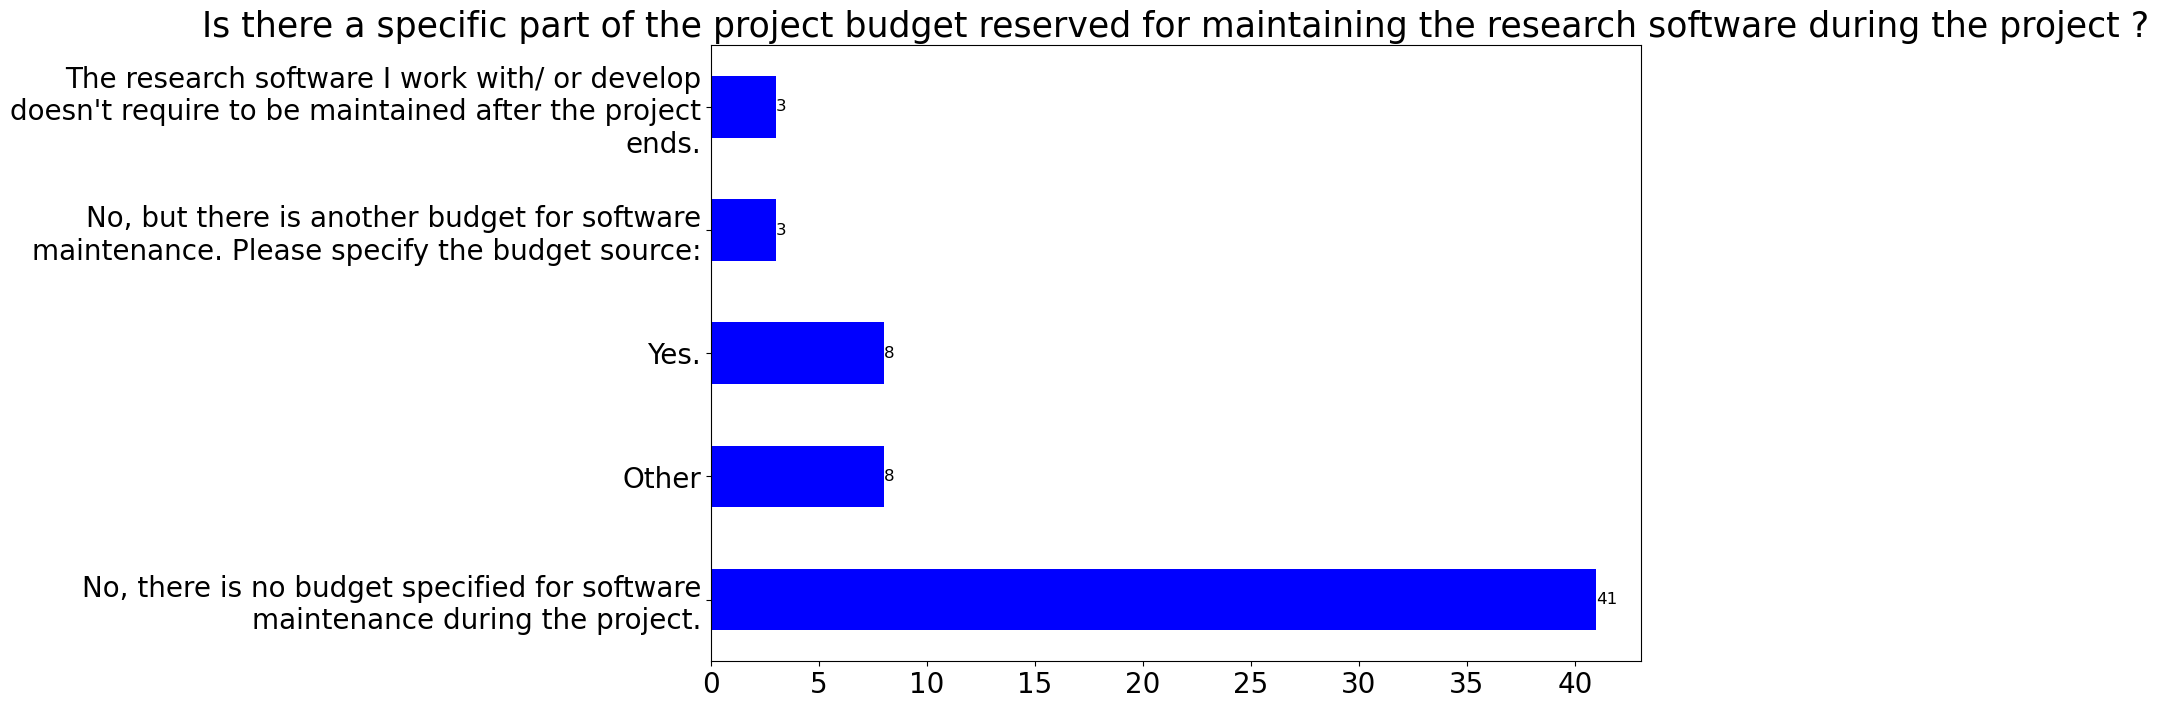

In [236]:
answer_counts= survey_data['Q11 Is there a specific part of the project budget reserved for maintaining the research software during the project? - Selected Choice'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
ax = answer_counts.plot(kind='barh', color='blue',fontsize=20)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('Is there a specific part of the project budget reserved for maintaining the research software during the project ?',
         fontsize=25)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=12)

plt.show()

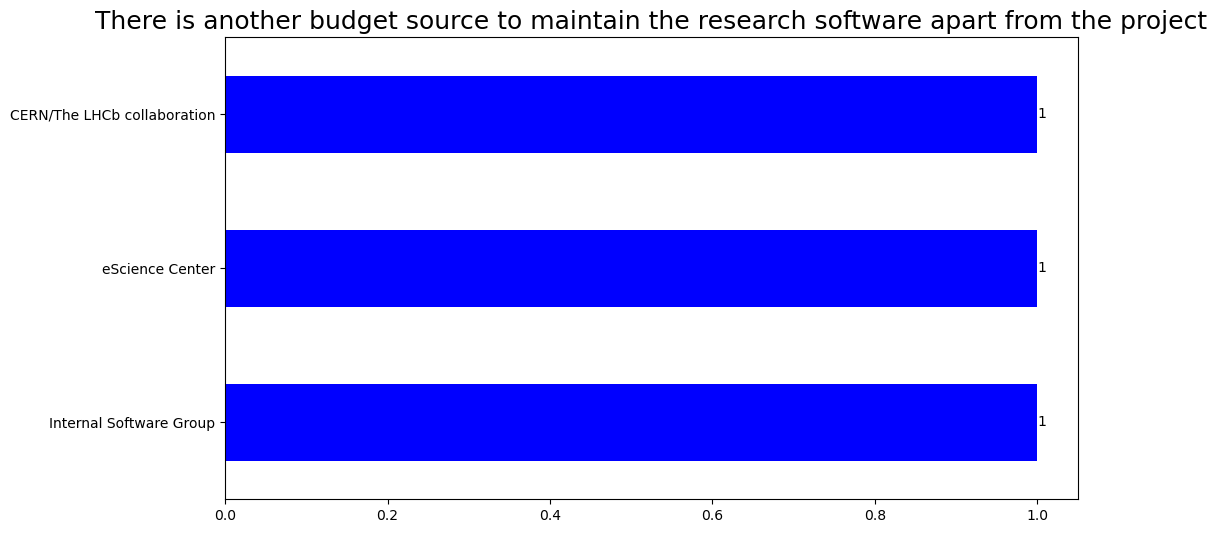

In [186]:
answer_counts= survey_data['Q11_2_TEXT Is there a specific part of the project budget reserved for maintaining the research software during the project? - No, but there is another budget for software maintenance. Please specify the budget source: - Text'].value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(11, 6))
ax = answer_counts.plot(kind='barh', color='blue')

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('There is another budget source to maintain the research software apart from the project', fontsize=18)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=10)

plt.show()

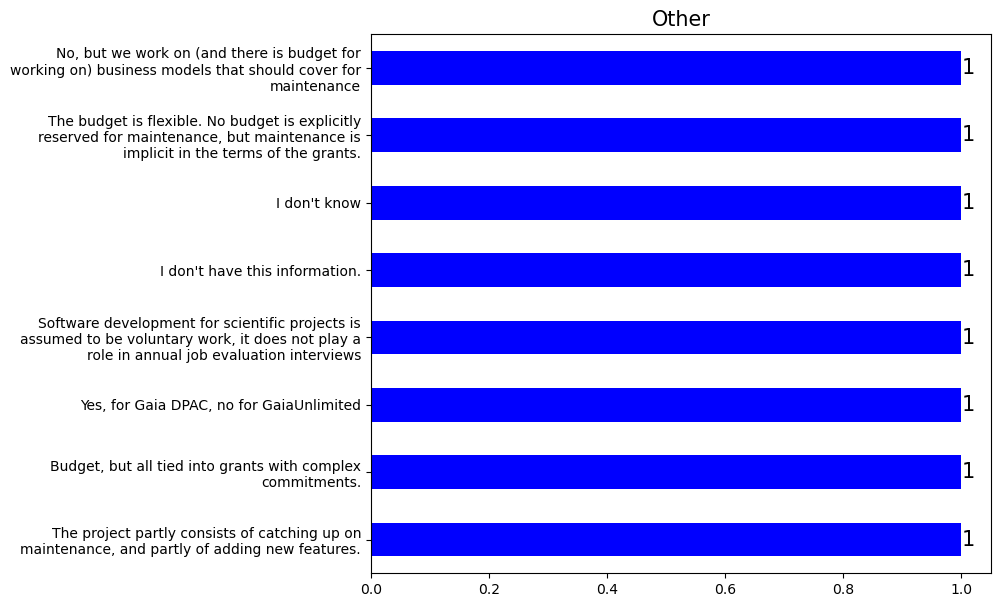

In [242]:
answer_counts= survey_data['Q11_5_TEXT Is there a specific part of the project budget reserved for maintaining the research software during the project? - Other - Text'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(8, 7))
ax = answer_counts.plot(kind='barh', color='blue')

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('Other', fontsize=15)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=15)

plt.show()
    
    

# Question 12

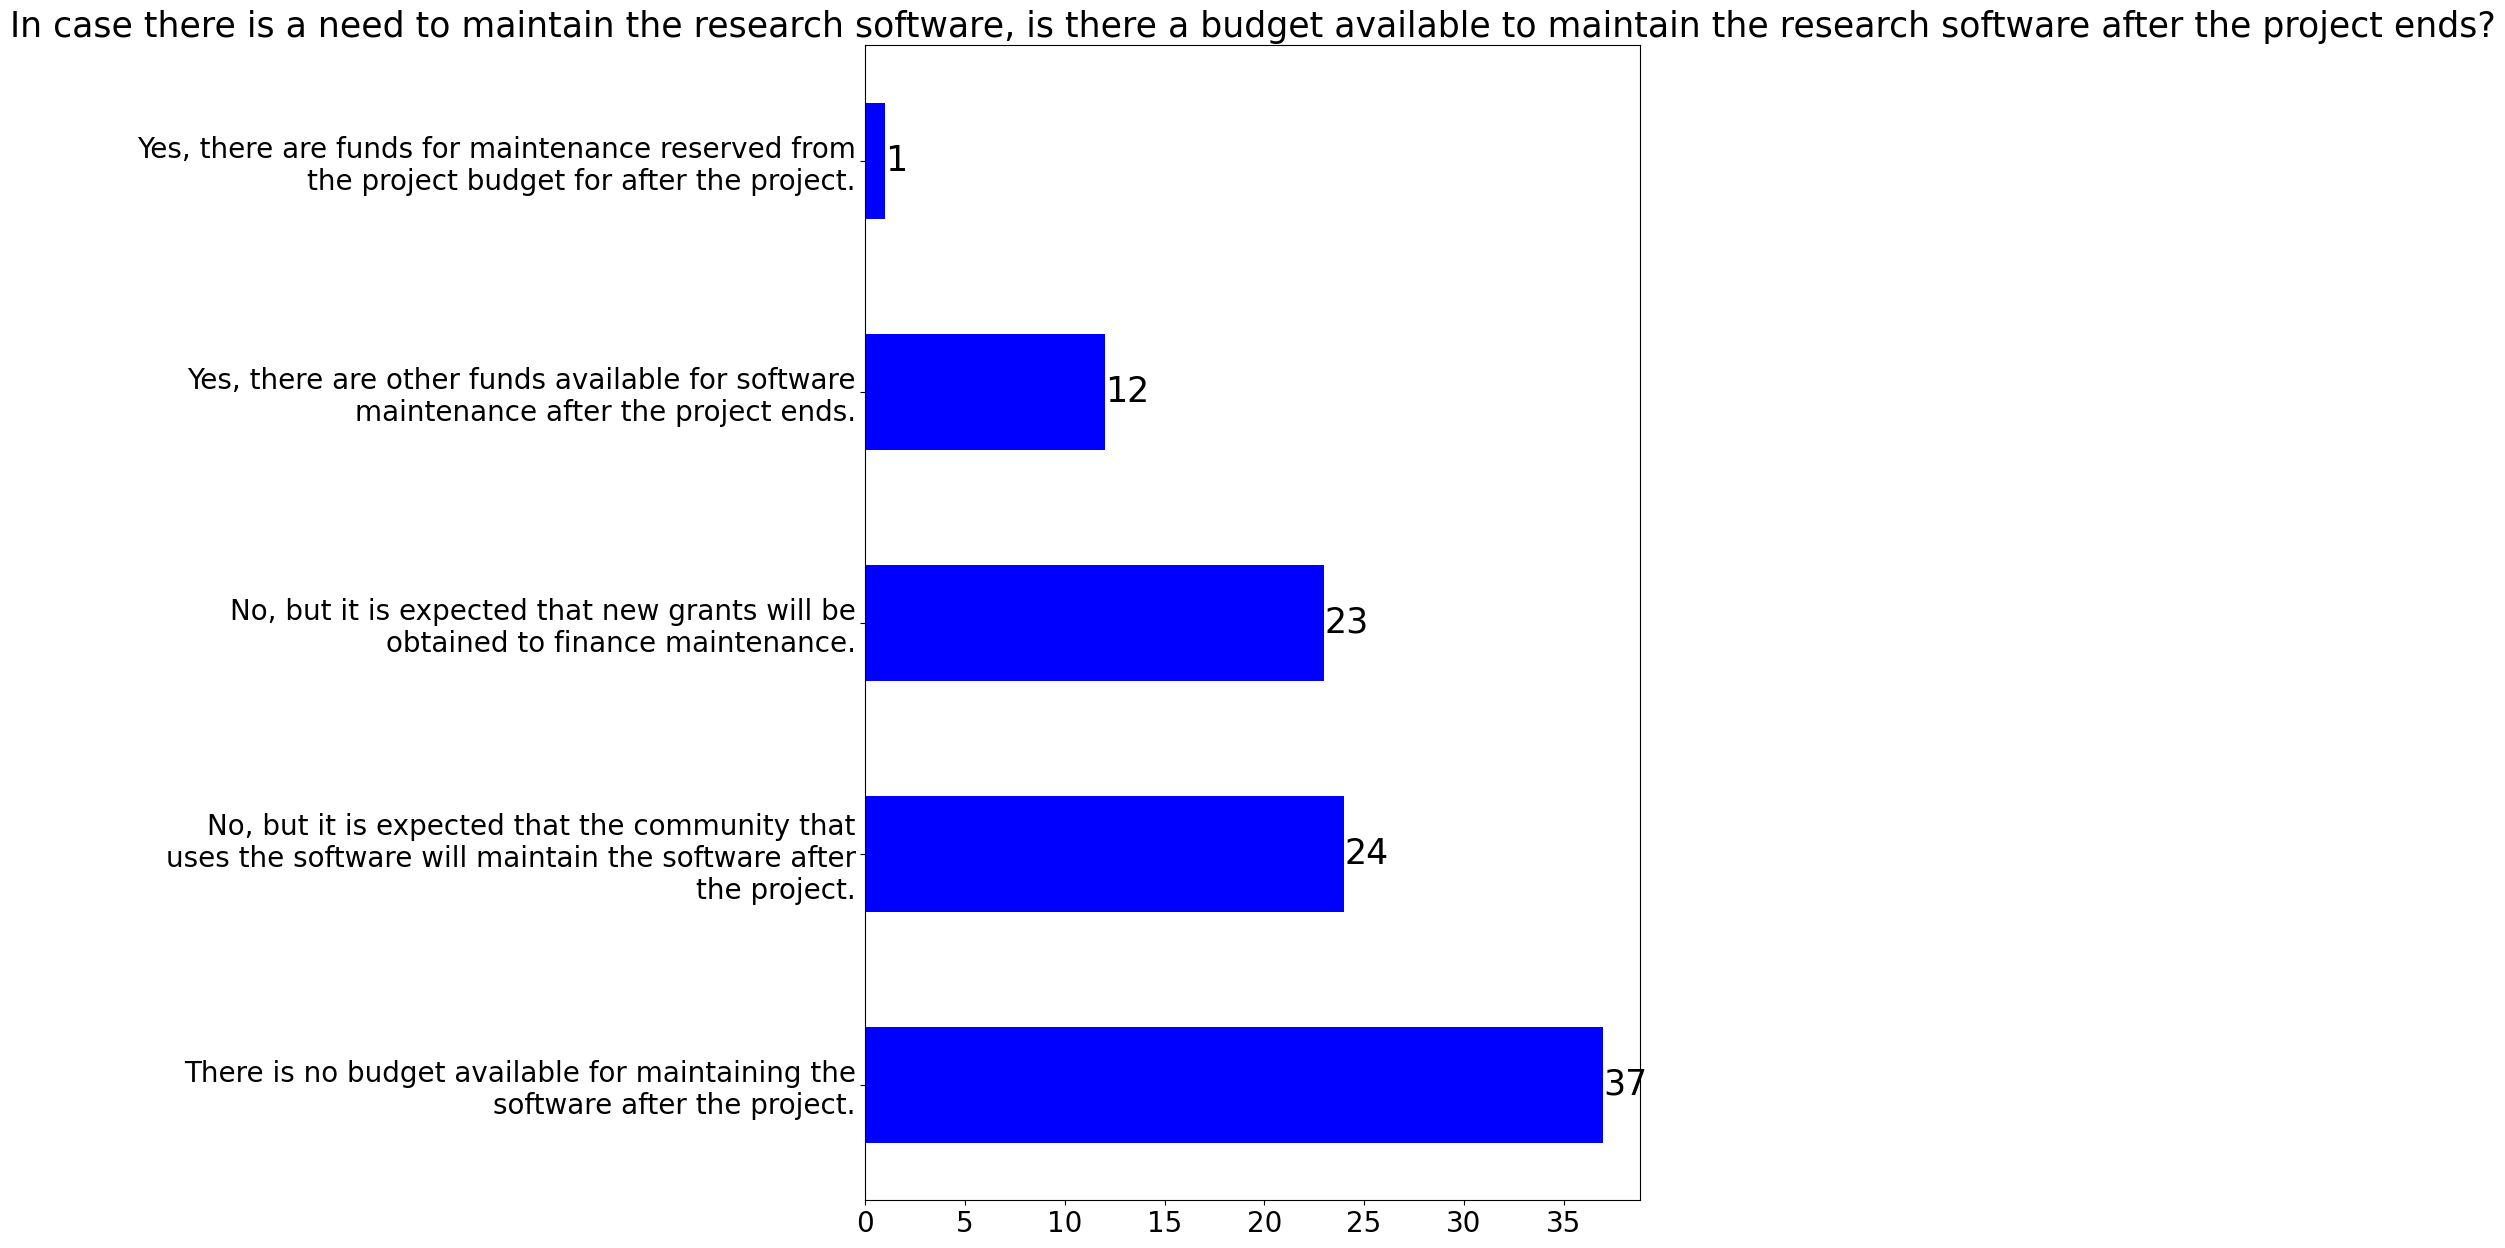

In [229]:
answer_counts= survey_data['Q12 In case there is a need to maintain the research software, is there a budget available, either through the grant that funds the project or through other means, to maintain the research software after the project ends?'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]


# Plot the horizontal bar chart
plt.figure(figsize=(10, 15))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=20)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
ax.set_yticklabels(wrapped_labels)
plt.title('In case there is a need to maintain the research software, is there a budget available to maintain the research software after the project ends?',fontsize='25')

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=25)

plt.show()


# Question 13

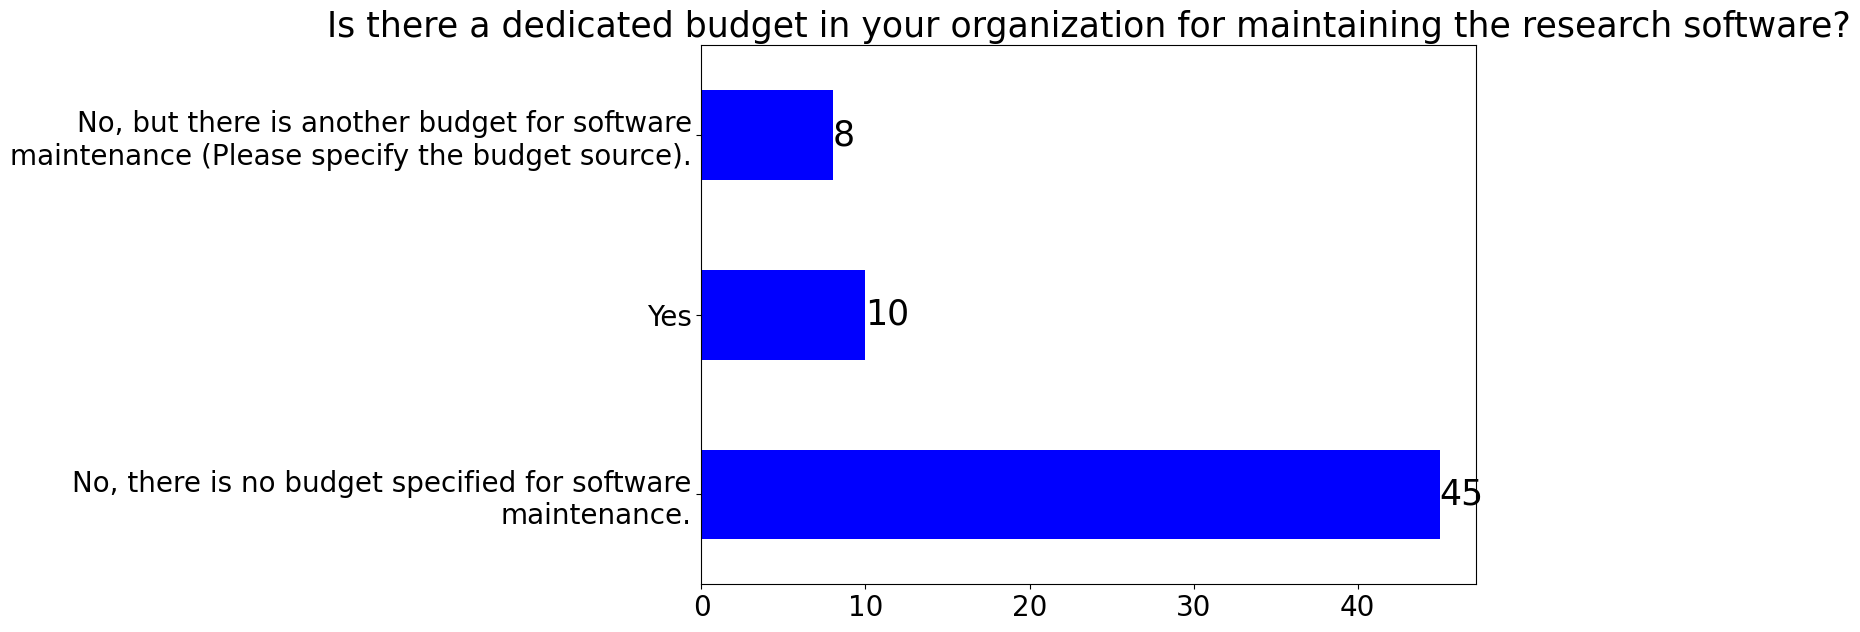

In [223]:
answer_counts= survey_data['Q13 Is there a dedicated budget in your organization for maintaining the research software? - Selected Choice'].value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 7))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=20)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('Is there a dedicated budget in your organization for maintaining the research software?',fontsize='25')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=25)

plt.show()


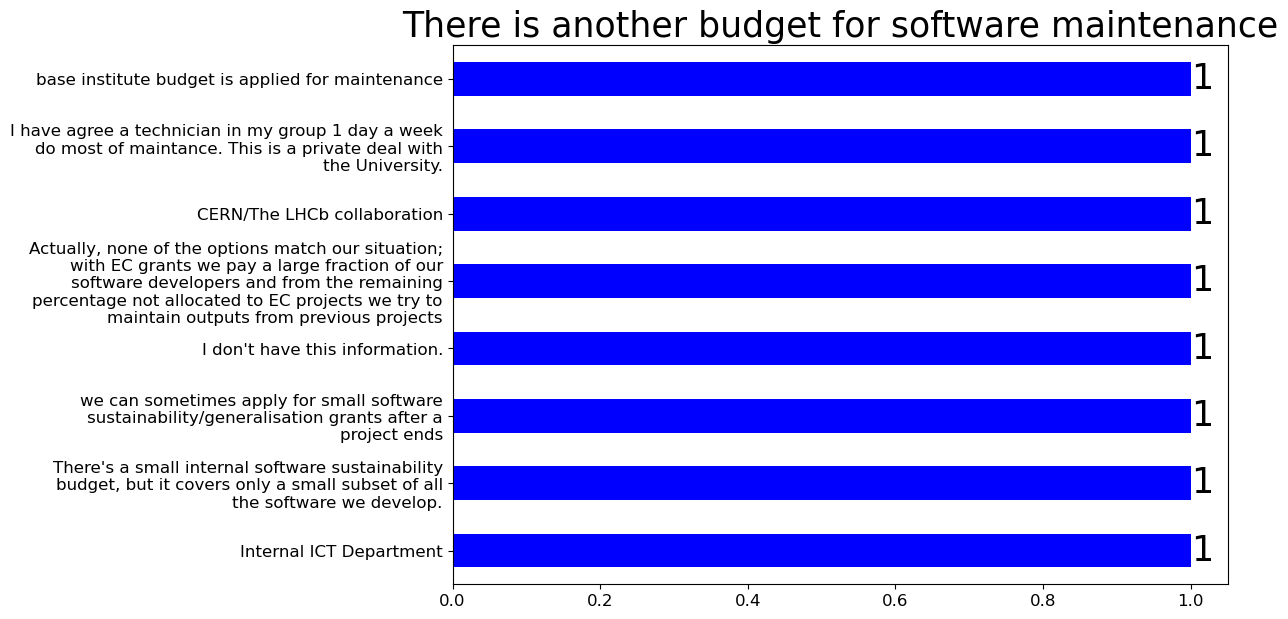

In [219]:


# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 7))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=12)

# Set the wrapped labels as the y-axis tick labels
ax.set_yticklabels(wrapped_labels)

# Add labels and title
plt.title('There is another budget for software maintenance', fontsize=25)

# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, wrapped_labels)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=25)

plt.show()


# Question 14

In [2]:
# Load the survey data from the Excel file
file_path = 'question_14.xlsx'
q14_data = pd.read_excel(file_path, index_col=False)

In [3]:
q14_data.iloc[9:12:,0:2]

Summary of Do you know why there is no dedicated budget for maintaining the research software? - Selected Choice  \
9   I do not know and have no idea why there is no...                                                                 
10  I do not know for sure, but I think I know the...                                                                 
11  I do know why there is no dedicated budget for...                                                                 

   Unnamed: 1  
9          14  
10         19  
11         12

In [4]:
q14_data.columns

Index(['Summary of Do you know why there is no dedicated budget for maintaining the research software? - Selected Choice',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],
      dtype='object')

In [5]:
# Rename column with a long name to a shorter, more manageable name
q14_data.rename(columns={
'Summary of Do you know why there is no dedicated budget for maintaining the research software? - Selected Choice': 
'Question_14',
'Unnamed: 1': 'Count'
}, inplace=True)

q14_data.columns

Index(['Question_14', 'Count', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
q14_data.iloc[9:12:,0:2]

Question_14 Count
9   I do not know and have no idea why there is no...    14
10  I do not know for sure, but I think I know the...    19
11  I do know why there is no dedicated budget for...    12

C:\Users\P256980\AppData\Local\Temp\ipykernel_22516\3923170703.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=13)


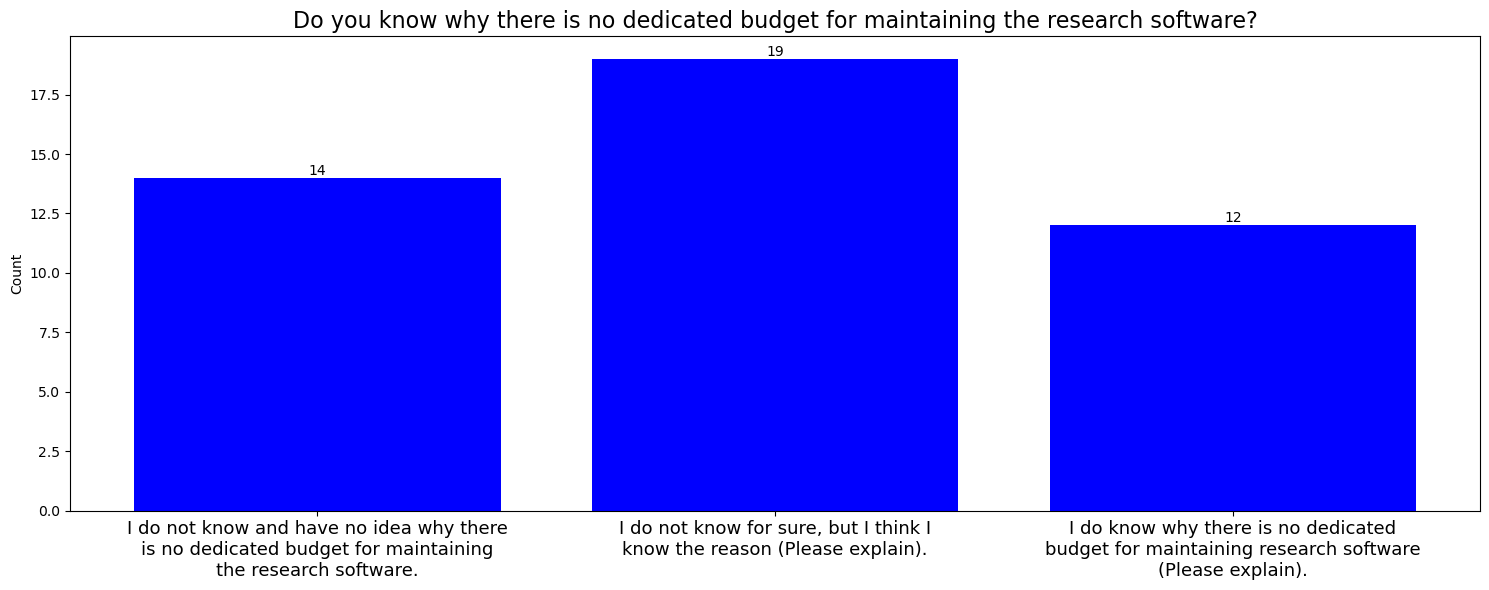

In [14]:
answer_counts= q14_data.iloc[9:12:,0:2]

subset = q14_data[['Question_14', 'Count']].iloc[9:12, 0:2]

# Set the maximum width for each line of text in the x-axis labels
max_width = 40  # Adjust this width based on your preference

# Wrap the long text in the x-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in subset['Question_14']]

plt.figure(figsize=(15, 6))
bars = plt.bar(subset['Question_14'], subset['Count'], color='blue')

# Annotate each bar with its height
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.ylabel('Count')

# Get the current axes
ax = plt.gca()

# Set the wrapped labels as x-tick labels
ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=13)

plt.title('Do you know why there is no dedicated budget for maintaining the research software?', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
subset = q9_data.iloc[9:16, 0:2]

plt.figure(figsize=(14, 8))
bars = plt.barh(subset['Question_9'], subset['Count'], color='blue')

plt.title('Is the research software you develop is part of a project? Do you know how this project is funded?', fontsize=18)

# Display counts on bars
for bar in bars:
    # Get the width (i.e., the count) of each bar
    count = bar.get_width()
    # Place the text at the end of each bar
    plt.text(count, bar.get_y() + bar.get_height() / 2, f'{int(count):,}', va='center', ha='left', fontsize=10, color='black')
    
plt.show()

# Question 15

In [ ]:
Q15 How is the funding available for maintaining the software code used? (More than one option can be selected) - Selected Choice

In [24]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q15 How is the funding available for maintaining the software code used? (More than one option can be selected) - Selected Choice': 
'Question_15',
'Q15_4_TEXT How is the funding available for maintaining the software code used? (More than one option can be selected) - Other (Please specify): - Text': 
'Question_15-text'
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [25]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_15_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_15']

# Display the result
print(question_15_finished)


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
162    NaN
163    NaN
164    NaN
165    NaN
167    NaN
Name: Question_15, Length: 100, dtype: object


In [32]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_15_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_15-text']

# Display the result
print(question_15_finished)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
162   NaN
163   NaN
164   NaN
165   NaN
167   NaN
Name: Question_15-text, Length: 100, dtype: float64


In [33]:
question_15_finished.unique()

array([nan])

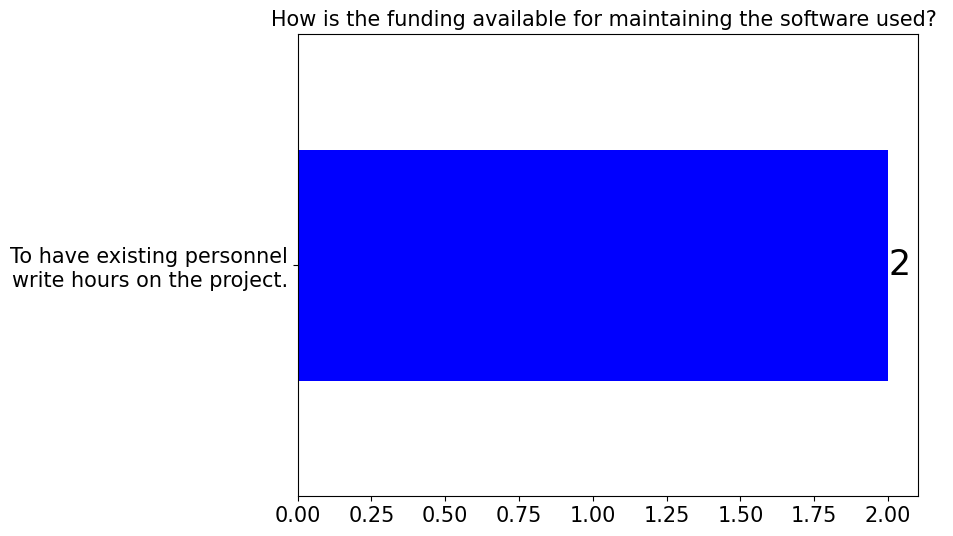

In [31]:
answer_counts= question_15_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 30  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(8, 6))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=15)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('How is the funding available for maintaining the software used? ',fontsize='15')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=25)

plt.show()


# Question 16

In [34]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q16 How much of the project budget is reserved for software maintenance? - Selected Choice':
 'Question_16',
'Q16_1_TEXT How much of the project budget is reserved for software maintenance? - Please fill in a percentage of your project budget that is reserved for software maintenance. - Text':
 'Question_16-text'   
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [40]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_16_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_16-text']

# Display the result
print(question_16_finished.value_counts())

0                                                                                                                                                   17
0%                                                                                                                                                   4
20                                                                                                                                                   2
10                                                                                                                                                   2
3-5%                                                                                                                                                 1
Chnages from project to project but around 50%                                                                                                       1
See answer to Q15: depends on how much external funding we manage to get - everything is "base

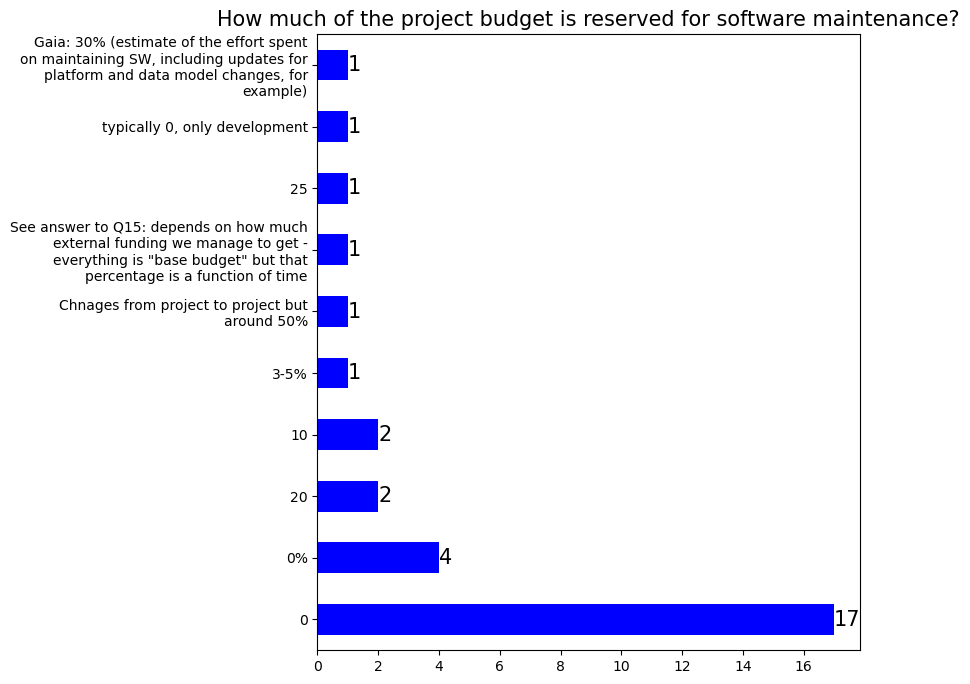

In [44]:
answer_counts= question_16_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 40  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(7, 8))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=10)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('How much of the project budget is reserved for software maintenance?',fontsize='15')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=15)

plt.show()


# Question 17

In [45]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q17 Are the people responsible for maintaining the research software you work on (including yourself) explicitly tasked with this responsibility in their job description or annual work plan?':
 'Question_17'  
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [46]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_17_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_17']

# Display the result
print(question_17_finished.value_counts())

No.              59
Yes.             27
I don't know.    11
Name: Question_17, dtype: int64


In [53]:
answer_counts= question_17_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 40  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(11, 7))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=18)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('Are the people responsible for maintaining the research software you work on explicitly tasked with this responsibility in their job description or annual work plan?',fontsize='18')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=17)

plt.show()


# Question 18

In [54]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q18 What is the career stage or job title of the individuals responsible for maintaining the research software you work with (including yourself)? - Selected Choice':
 'Question_18',
 'Q18_8_TEXT What is the career stage or job title of the individuals responsible for maintaining the research software you work with (including yourself)? - Other (Please specify): - Text':
 'Question_18-text'   
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [59]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_18_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_18-text']

# Display the result
print(question_18_finished.value_counts())

Multiple of the above                                                  2
Diverse: Full professor, Tenured Researcher, Lecturer, Postdoc, RSE    1
graduated students who left to industry                                1
Everyone in my group helps                                             1
UD, Post-Doc, PhD and MSc students in projects                         1
Technician                                                             1
faculty level                                                          1
PhD students and MSc students                                          1
A mix of postdocs and permanent research staff                         1
all of the above                                                       1
All of the above.                                                      1
I do not know                                                          1
whoever has time/need                                                  1
Don't know                                         

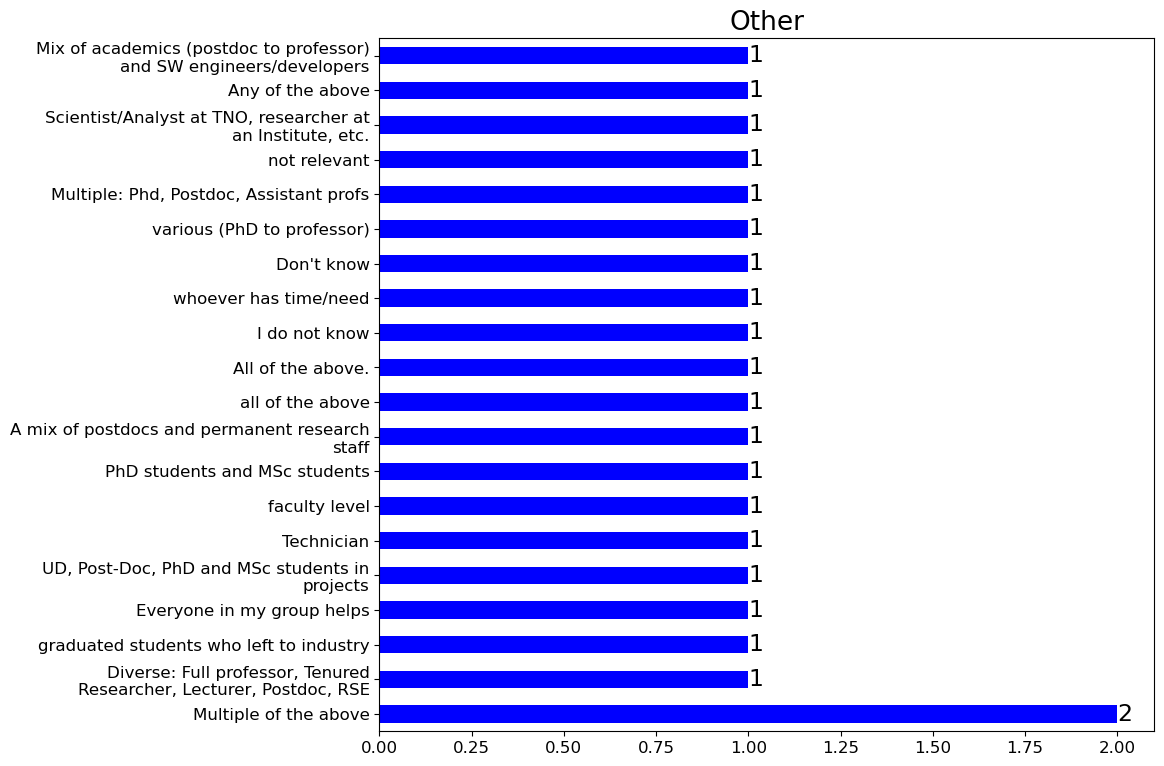

In [64]:
answer_counts= question_18_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 40  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 9))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=12)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('Other',fontsize='19')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=17)

plt.show()


# Question 19

In [65]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q19 How much of the contract time of the individuals responsible for maintaining the research software you work with (including yourself) is allocated for software maintenance? - Selected Choice':
'Question_19',
'Q19_1_TEXT How much of the contract time of the individuals responsible for maintaining the research software you work with (including yourself) is allocated for software maintenance? - Please fill in a percentage of the contract-time that is reserved for software maintenance. - Text':
'Question_19-text'   
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [73]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_19_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_19-text']

# Display the result
print(question_19_finished.value_counts())

0            11
0%            7
20            3
10            3
25            2
Voluntary     1
100           1
Varies        1
60%           1
Name: Question_19-text, dtype: int64


In [75]:
answer_counts= question_19_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 10))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=20)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('How much of the contract time of the individuals responsible for maintaining the research software you work with is allocated for software maintenance?',fontsize='19')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=19)

plt.show()


# Question 20

In [76]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q20 How much of the actual working time of the individuals responsible for maintaining the research software you work with (including yourself) is dedicated to software maintenance? - Selected Choice':
'Question_20',
'Q20_1_TEXT How much of the actual working time of the individuals responsible for maintaining the research software you work with (including yourself) is dedicated to software maintenance? - Please fill in an estimated percentage of the actual work time that is used for software maintenance. - Text':
'Question_20-text'   
}, inplace=True)

survey_data.columns

Index(['Question 1', 'Question 1 - Text entry', 'Start Date', 'End Date',
       'ResponseId', 'Recorded Date', 'Finished',
       'Q7 Research software designed for a research group or community is often classified into three types:\n\n(T1) Contribution to Community: e.g., PhD students contributing to the software of larger scientific communities.\n\n(T2) Core Infrastructure: Research groups introducing novel research infrastructure, where the software becomes one of the infrastructural research services offered to their own group and beyond.\n(T3) Specific Methods: Software developed for specific experiments, such as controlling hardware, acquiring data, or processing data in specific manners.\n\n\nDoes the research software you work on or with fall into any of these categories? (More than one option can be selected.) If not, please indicate how you would classify the research software you work with. - Selected Choice',
       'Q7_4_TEXT Research software designed for a research grou

In [82]:
# Select rows where 'Finished' is True and extract 'Question 8' column
question_20_finished = survey_data.loc[survey_data['Finished'] == True, 'Question_20-text']

# Display the result
print(question_20_finished.value_counts())

10                                        7
20                                        5
5                                         4
20%                                       3
50                                        3
15                                        3
5%                                        2
30%                                       2
25                                        2
2                                         2
40                                        2
30                                        2
100                                       1
Varies                                    1
35%                                       1
10%                                       1
45                                        1
60%                                       1
0-1%                                      1
probably less than 10 across the group    1
1                                         1
Gaia mission: 30% (as estimated above)    1
Name: Question_20-text, dtype: i

In [84]:
answer_counts= question_20_finished.value_counts()

# Set the maximum width for each line of text in the y-axis labels
max_width = 50  # You can adjust this width based on your preference

# Wrap the long text in the y-axis labels
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=max_width)) for label in answer_counts.index]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 13))
ax = answer_counts.plot(kind='barh', color='blue', fontsize=20)

# Add labels and title
#plt.xlabel('Count')
#plt.ylabel('Answer')
plt.title('How much of the actual working time of the individuals responsible for maintaining the research software you work with is dedicated to software maintenance?',fontsize='20')
ax.set_yticklabels(wrapped_labels)
# Display counts on bars
for index, (value, label) in enumerate(zip(answer_counts, answer_counts.index)):
    ax.text(value, index, f'{value:,}', va='center', ha='left', color='black', fontsize=19)

plt.show()


# Question 21

In [ ]:
# Rename column with a long name to a shorter, more manageable name
survey_data.rename(columns={
'Q20 How much of the actual working time of the individuals responsible for maintaining the research software you work with (including yourself) is dedicated to software maintenance? - Selected Choice':
'Question_21',
'Q20_1_TEXT How much of the actual working time of the individuals responsible for maintaining the research software you work with (including yourself) is dedicated to software maintenance? - Please fill in an estimated percentage of the actual work time that is used for software maintenance. - Text':
'Question_21-text'   
}, inplace=True)

survey_data.columns